In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from pmdarima import auto_arima
from ruptures import Binseg
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)


In [2]:
import os
os.chdir('..')
import warnings
warnings.filterwarnings('ignore')

>>> ### Load Dataset

In [3]:
from scripts.data_loader import loadData
data=loadData()


>>> # Understanding The Data

In [4]:
data.head()

Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

### Find the information of the dataset

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB


In [6]:
print(f"minimum value = {data['Date'].min()}")
print(f"maximum value = {data['Date'].max()}")

minimum value = 01-Apr-02
maximum value = Sep 30, 2022


In [7]:
data.dtypes

Date      object
Price    float64
dtype: object

In [8]:
data.describe()

Price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000

### Check missing value

In [9]:
data.isna().sum()

Date     0
Price    0
dtype: int64

In [10]:
data['year'] = pd.to_datetime(data['Date']).dt.year
print(data['year'].head())

0    1987
1    1987
2    1987
3    1987
4    1987
Name: year, dtype: int32


In [11]:
data['year'].describe()

count    9011.000000
mean     2004.612030
std        10.260414
min      1987.000000
25%      1996.000000
50%      2005.000000
75%      2014.000000
max      2022.000000
Name: year, dtype: float64

In [12]:
data['year'].isna().sum()

0

In [13]:
data['Date'] = pd.to_datetime(data['Date'])

In [14]:
data.head(10)

Date  Price  year
0 1987-05-20  18.63  1987
1 1987-05-21  18.45  1987
2 1987-05-22  18.55  1987
3 1987-05-25  18.60  1987
4 1987-05-26  18.63  1987
5 1987-05-27  18.60  1987
6 1987-05-28  18.60  1987
7 1987-05-29  18.58  1987
8 1987-06-01  18.65  1987
9 1987-06-02  18.68  1987

>> ## Oil Price Over Time

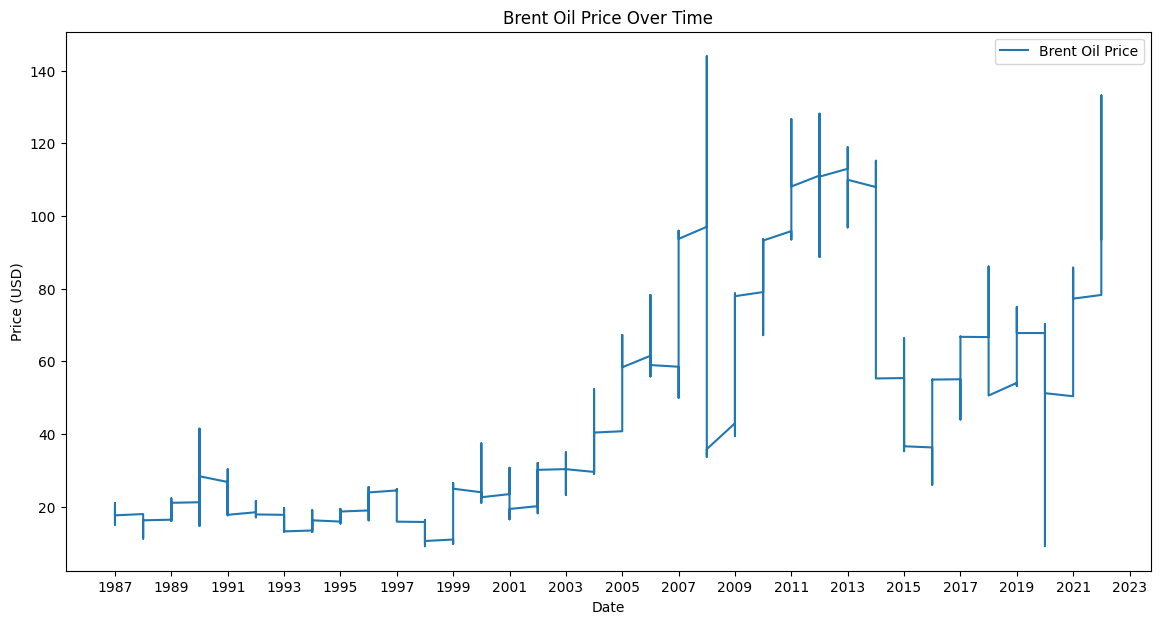

In [15]:
from scripts.plot import priceOverTime
priceOverTime(data)

>> ## Change Point Analysis

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


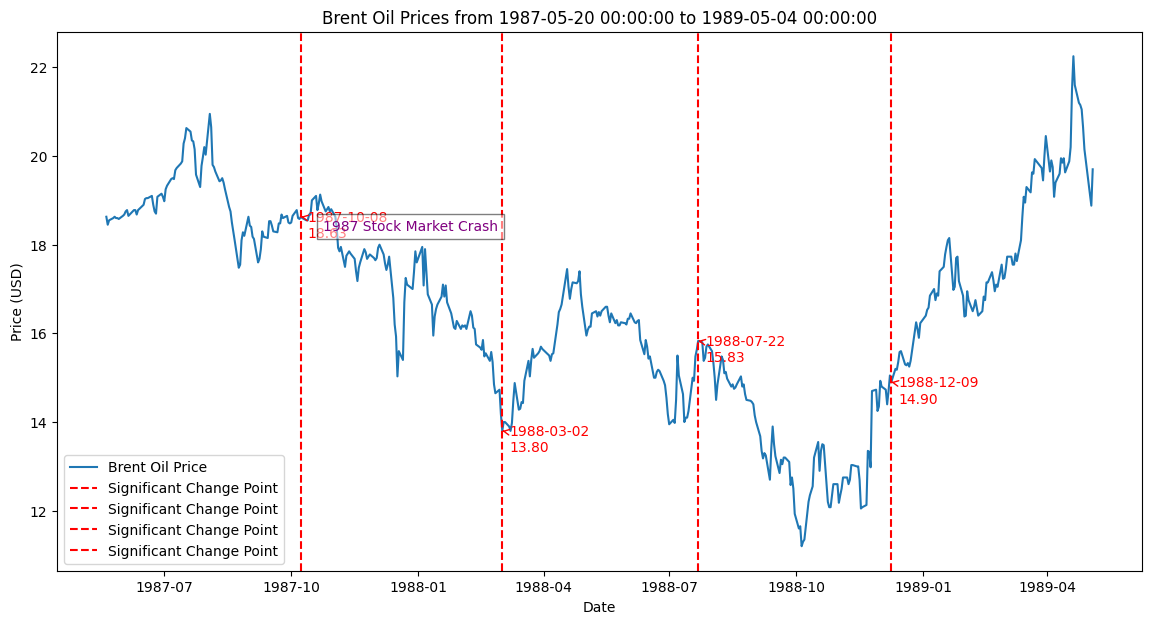

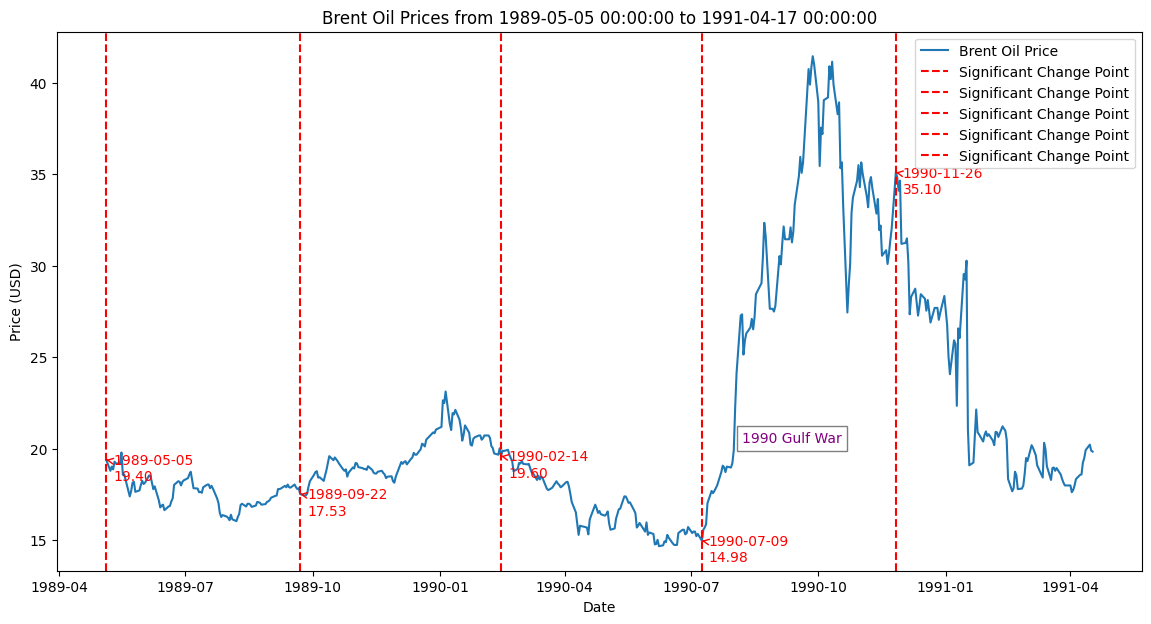

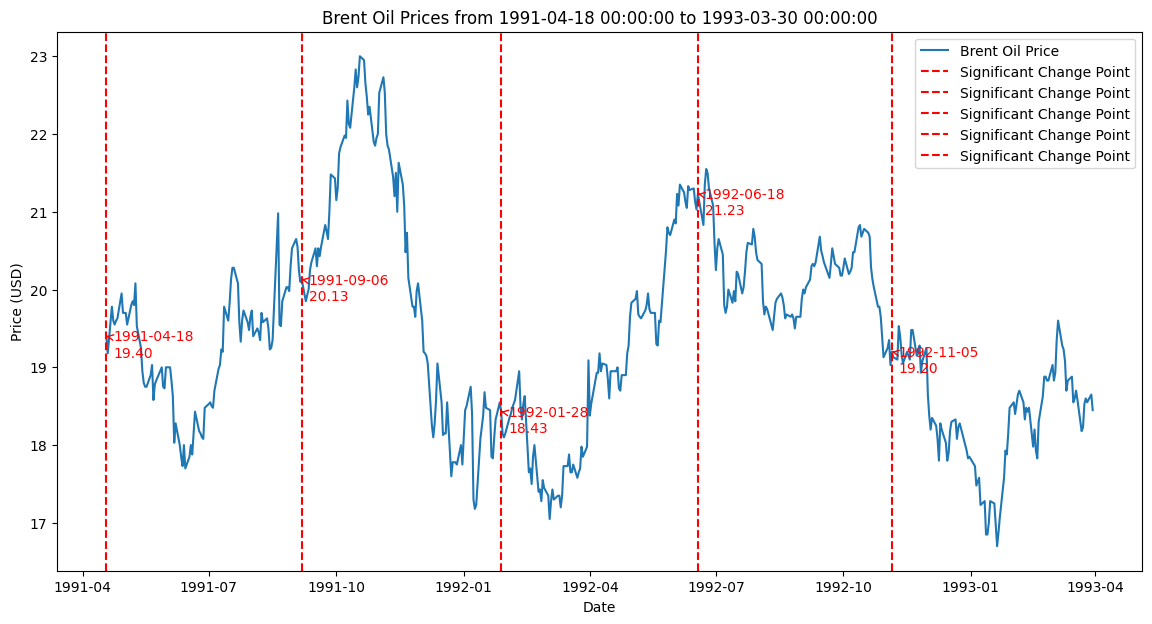

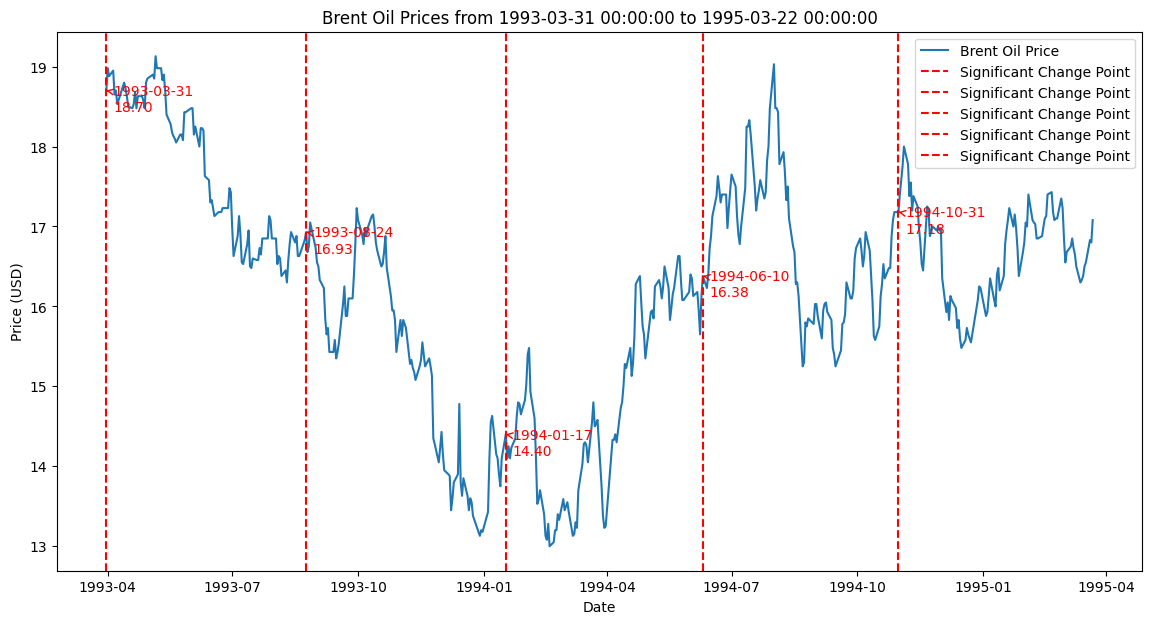

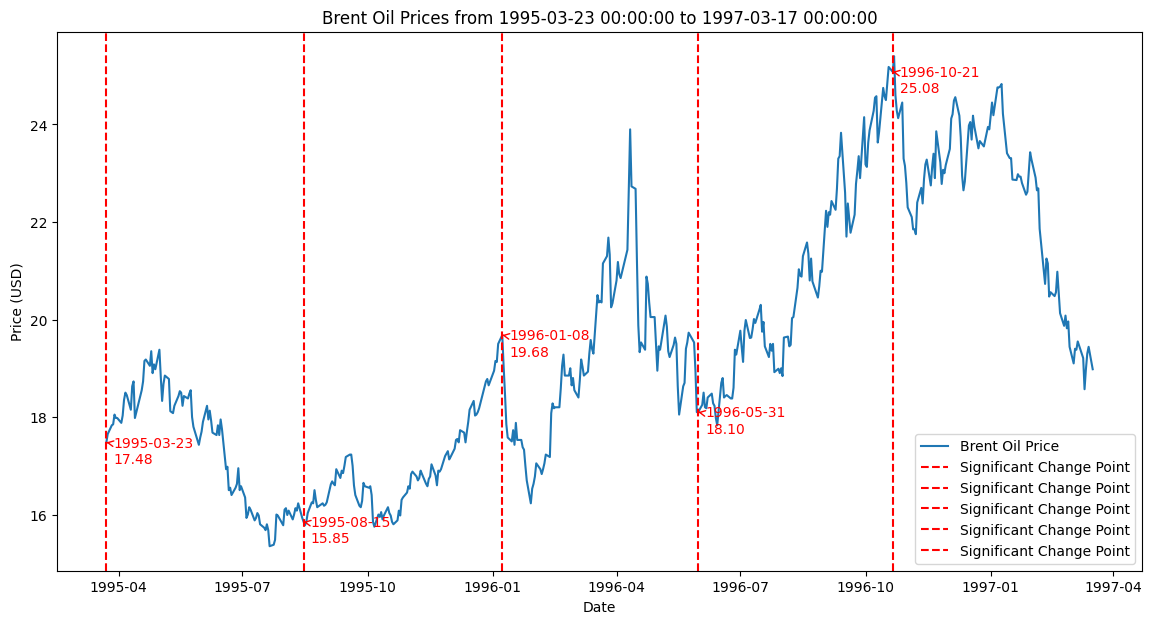

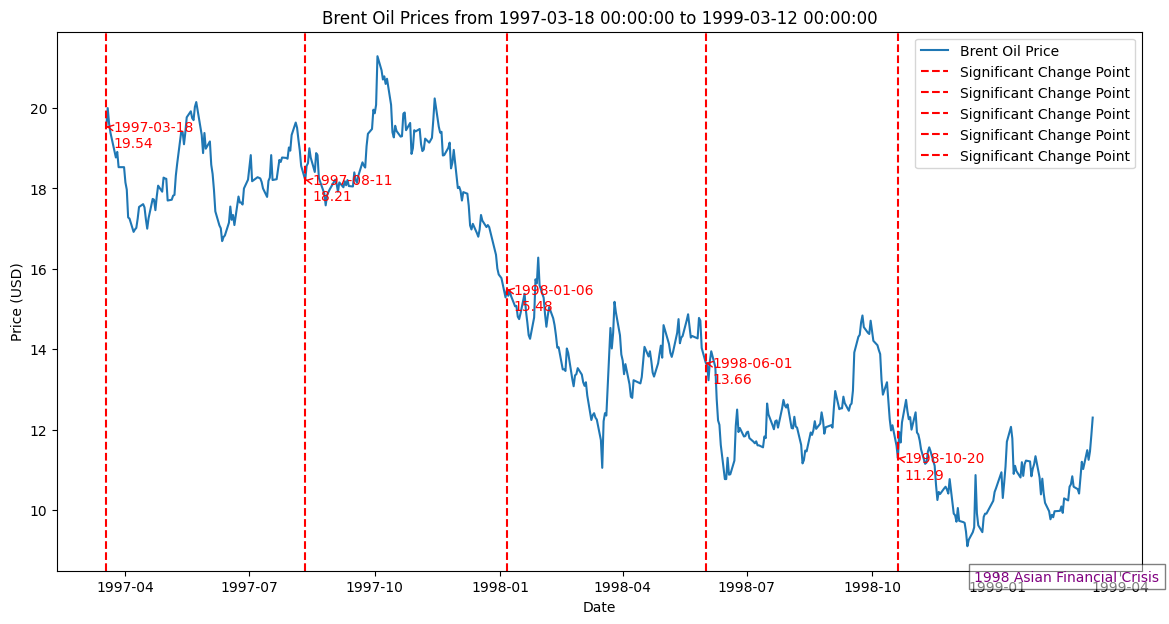

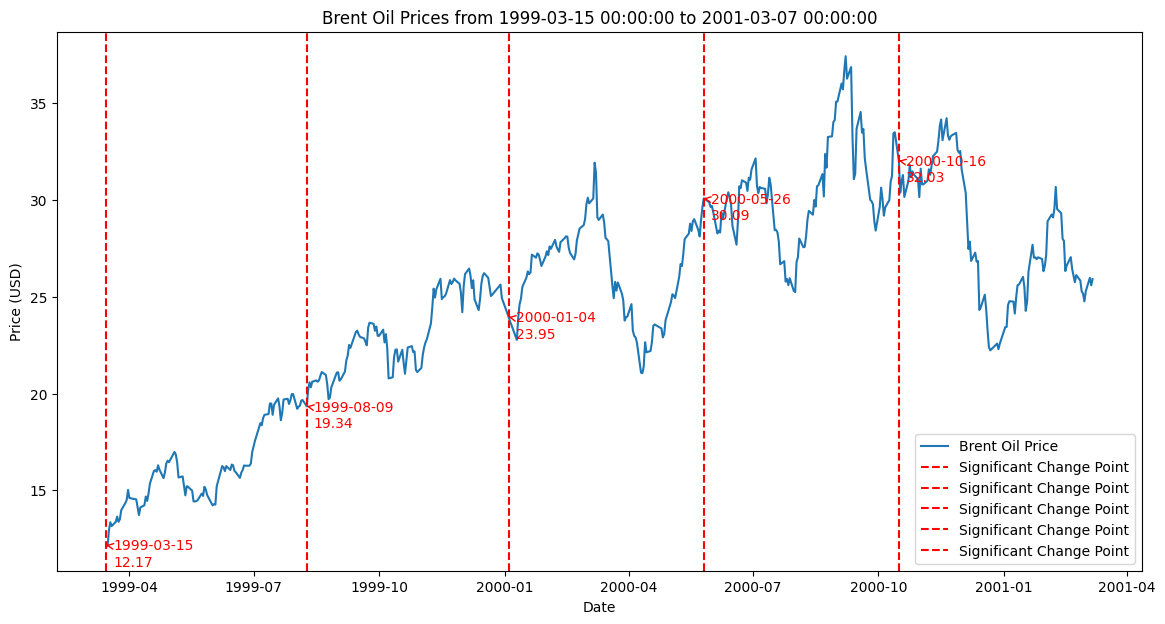

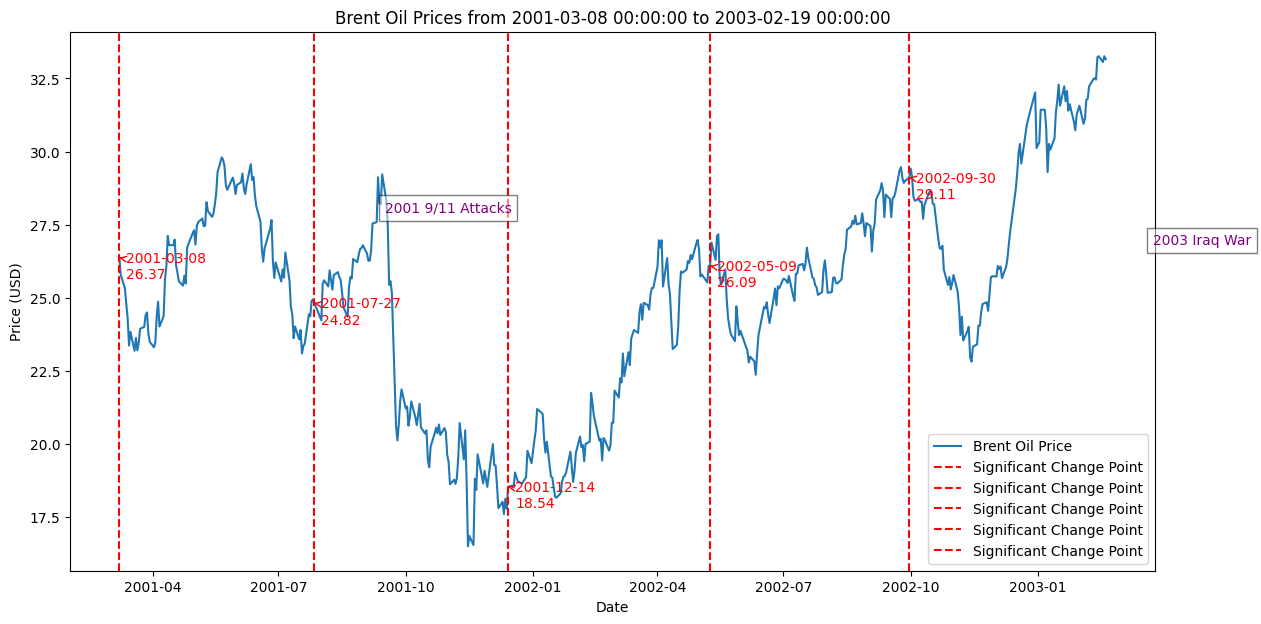

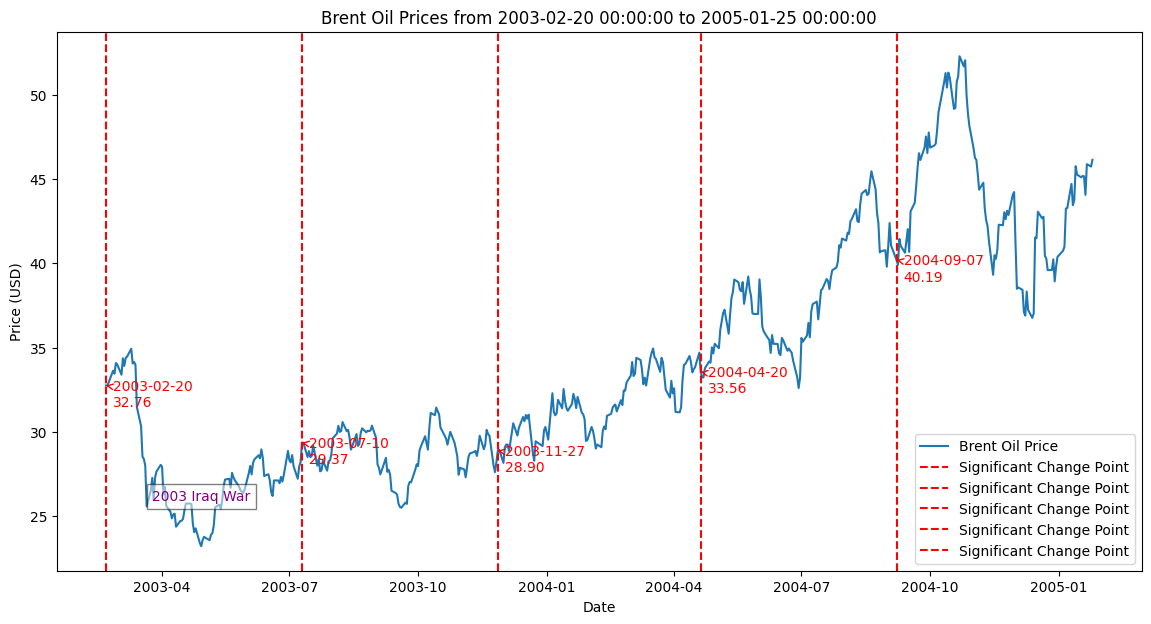

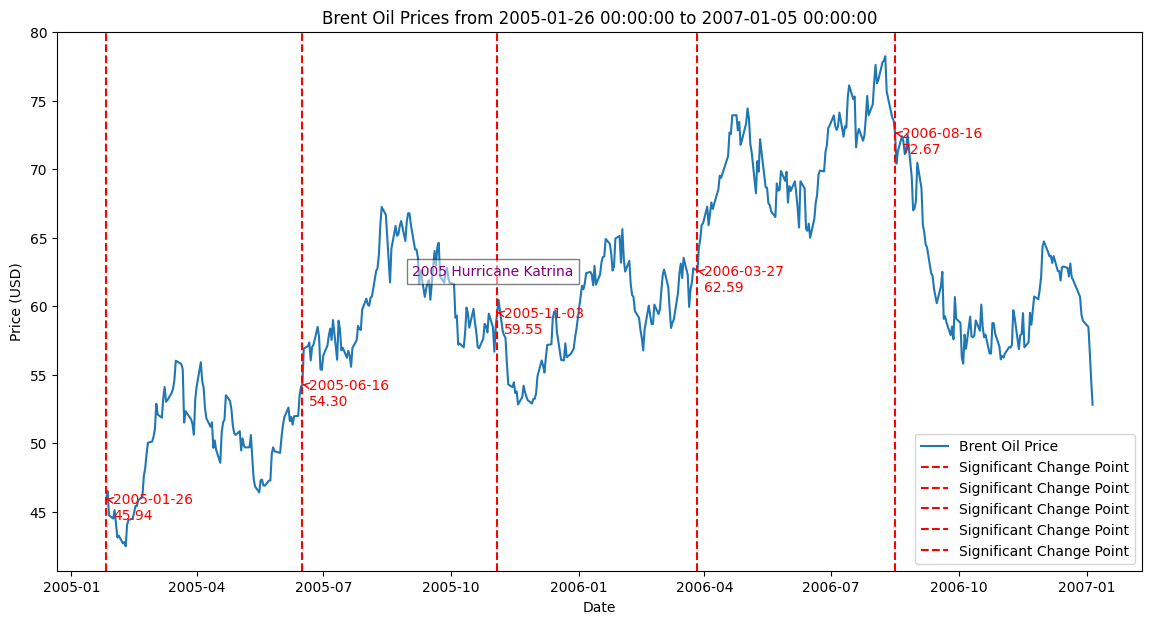

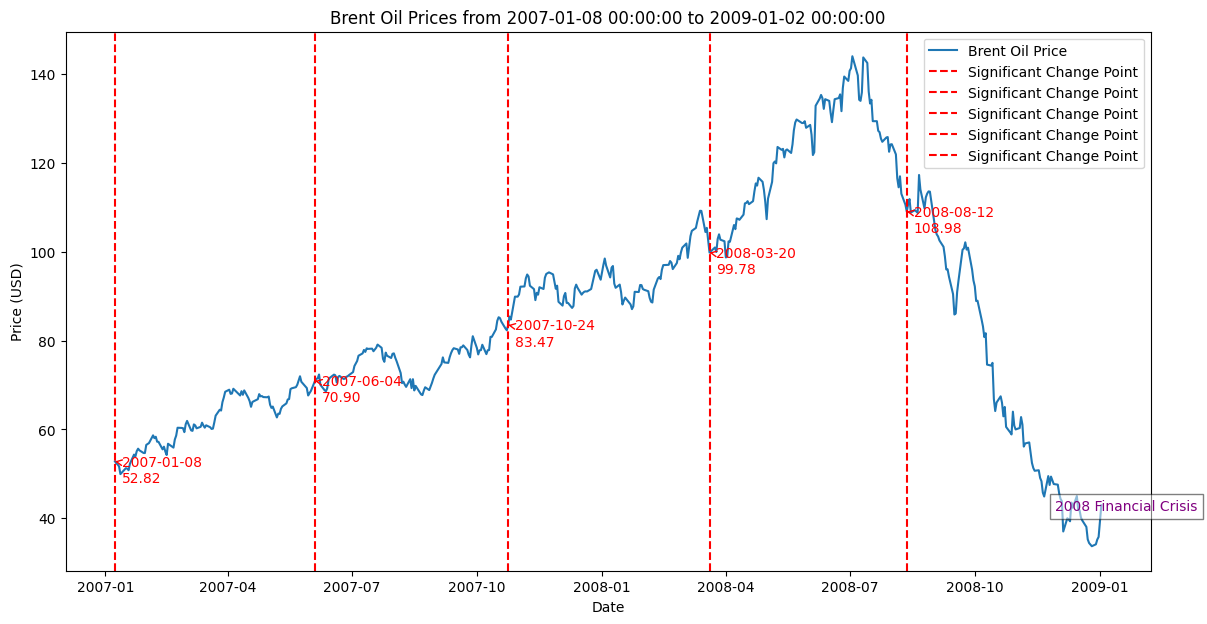

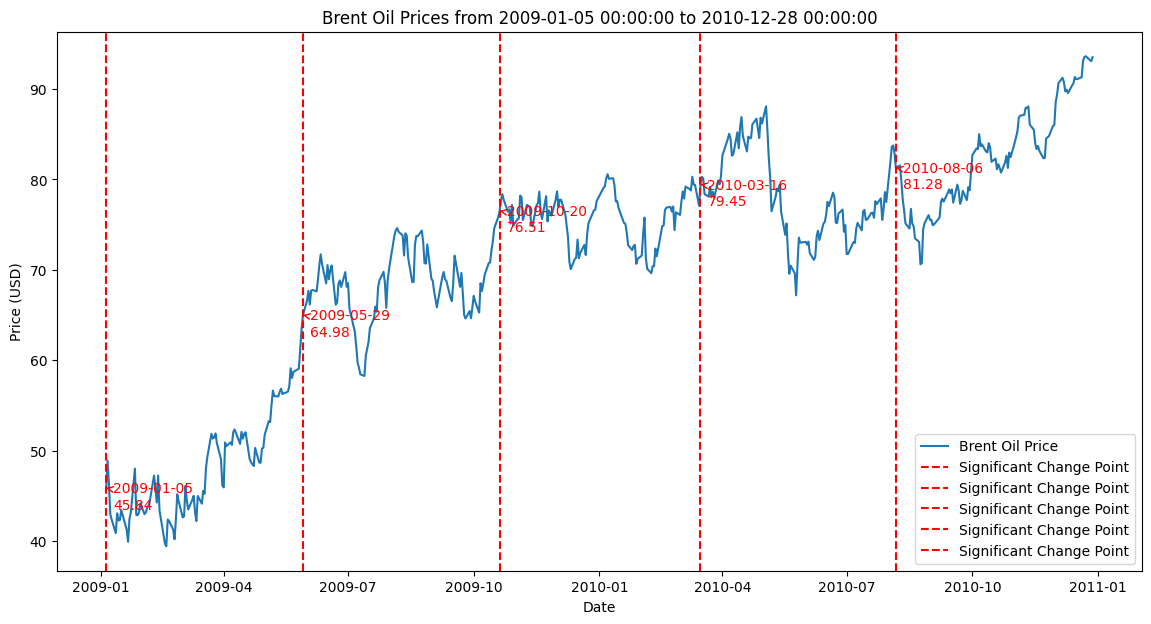

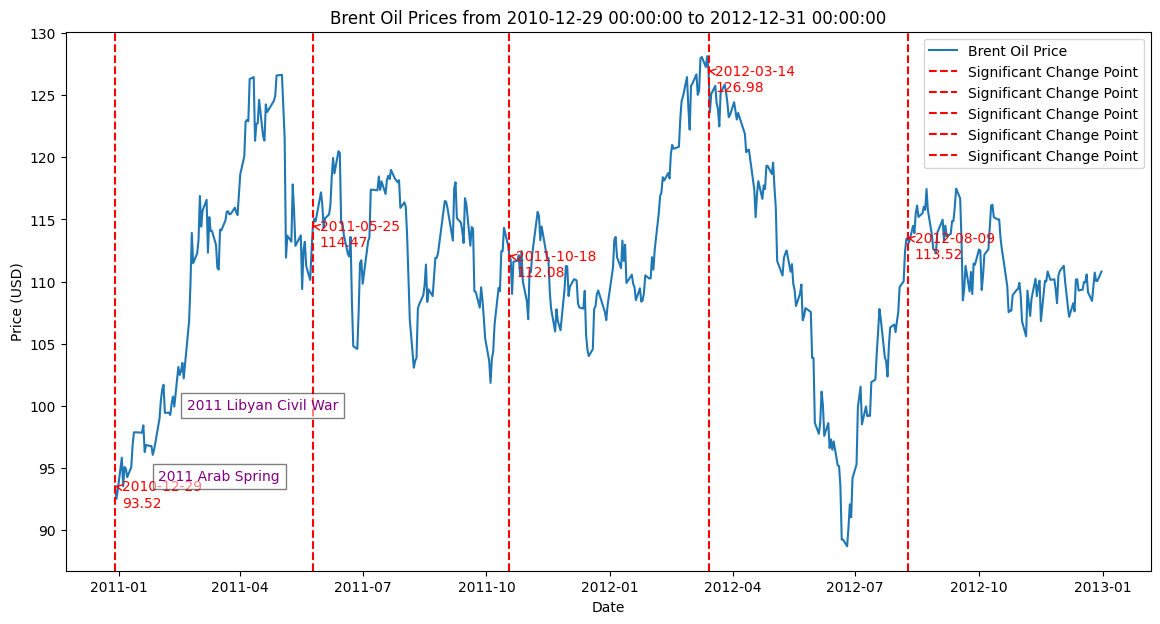

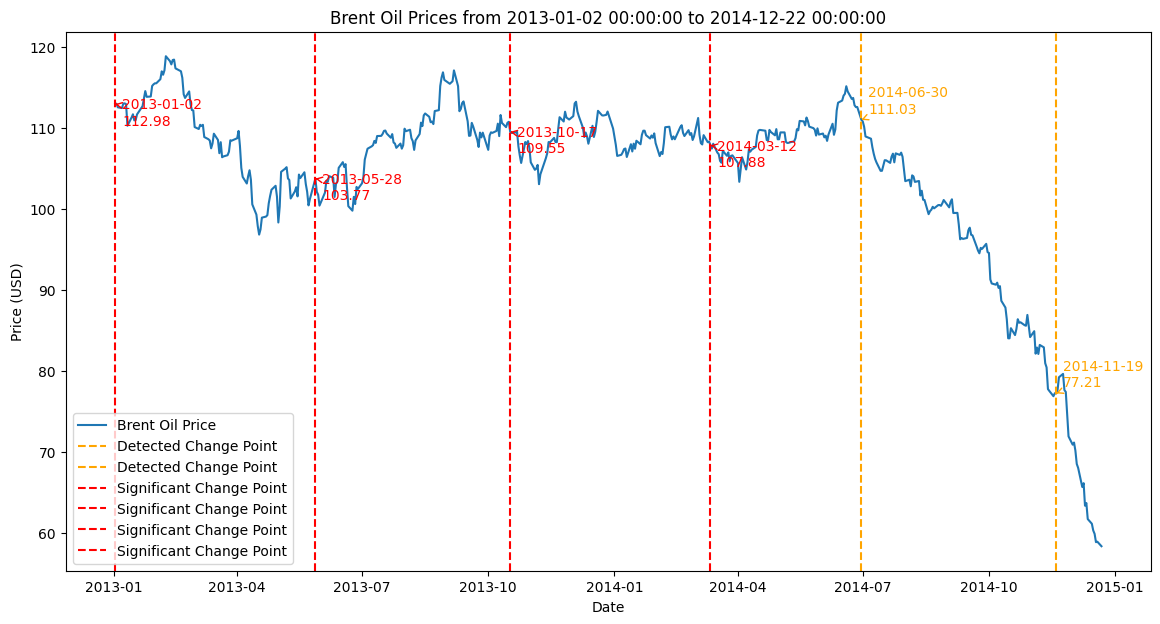

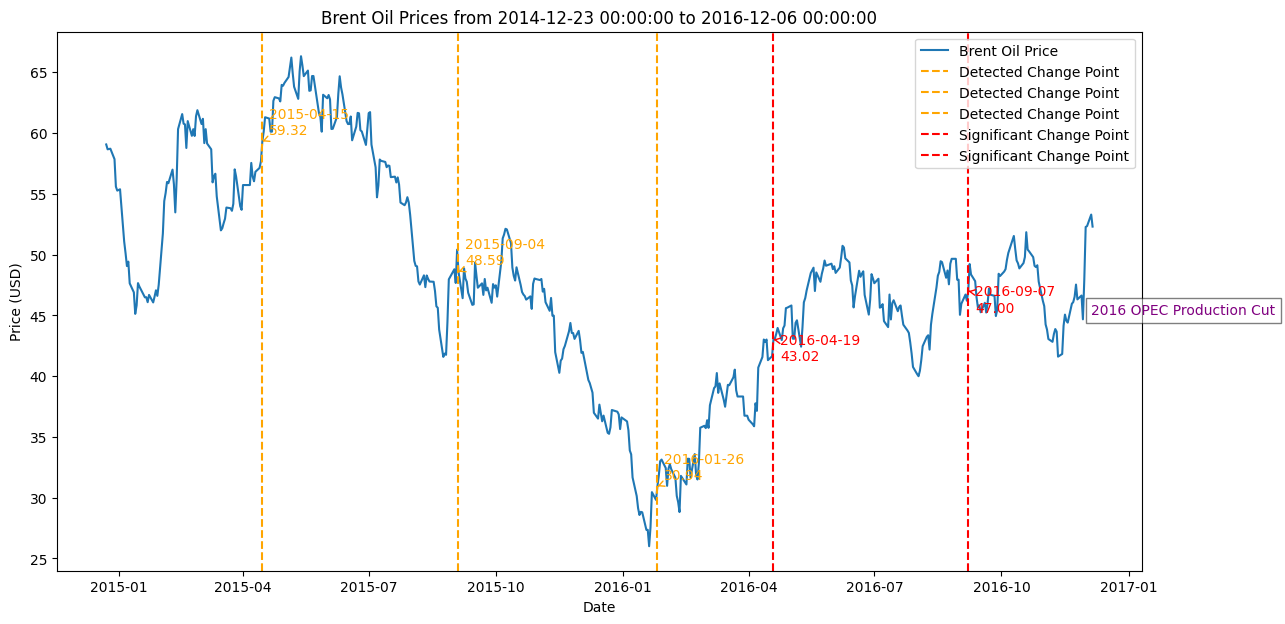

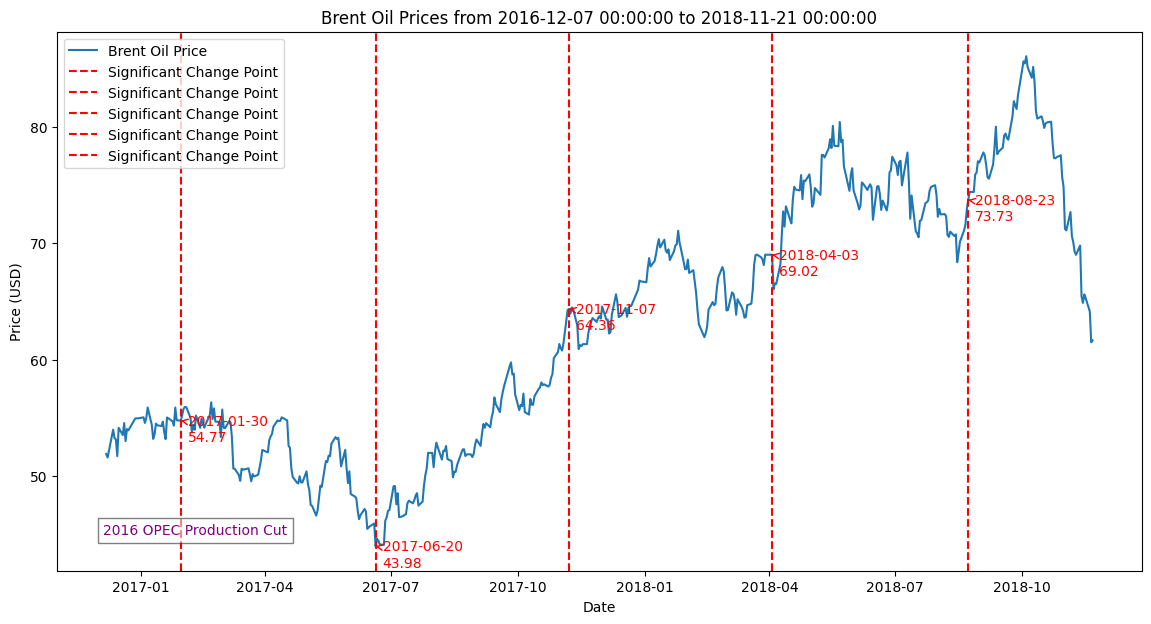

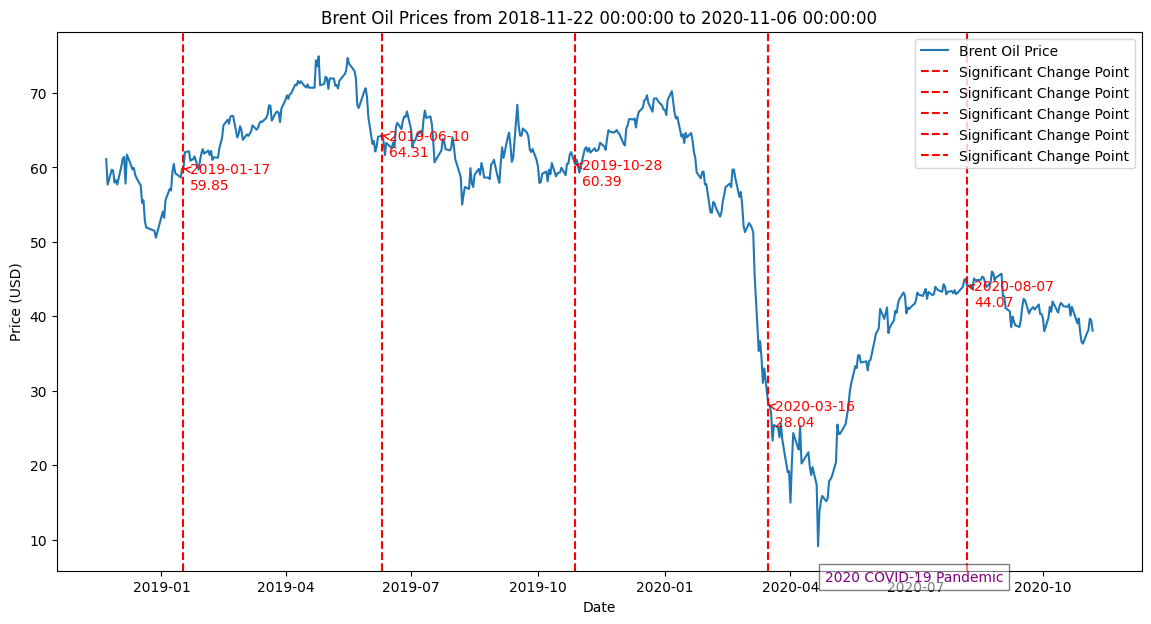

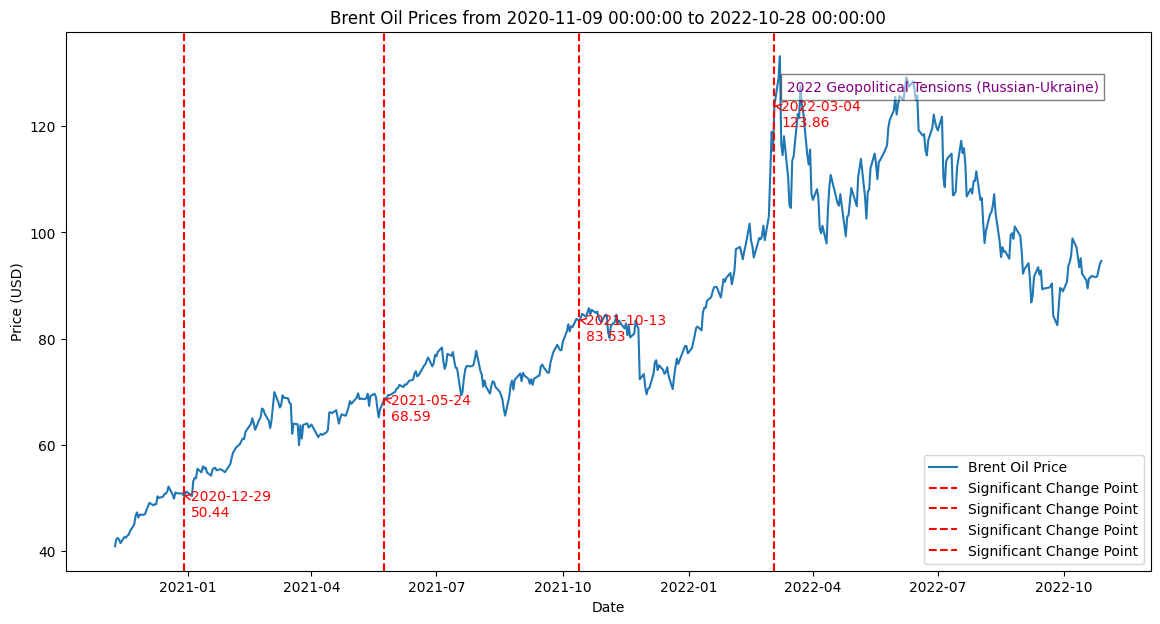

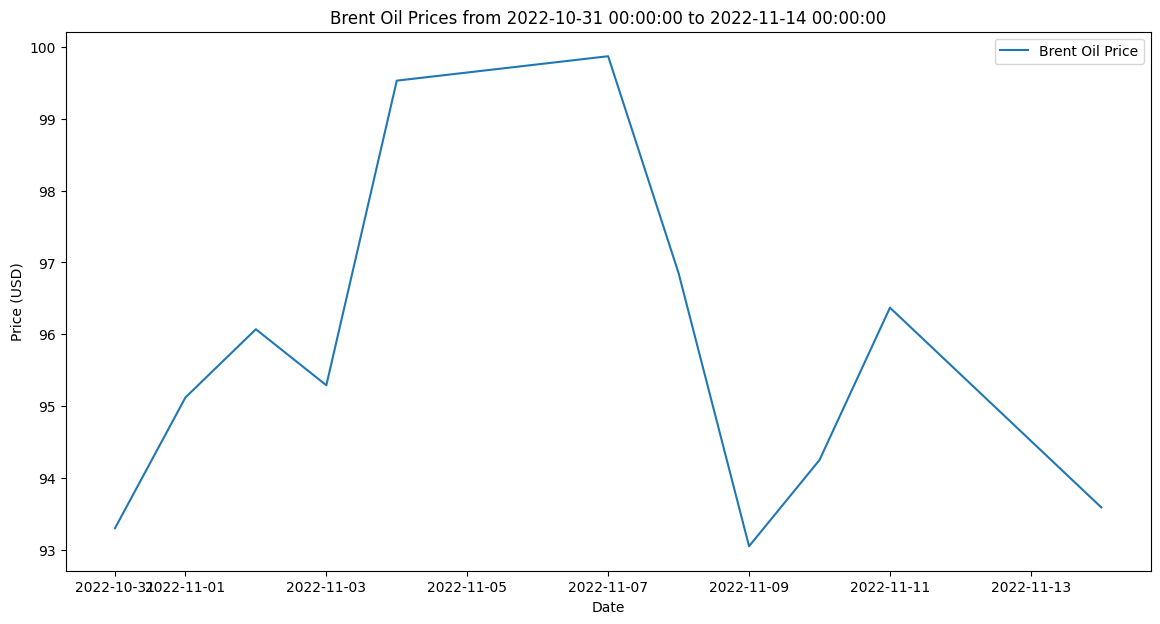

Detected Change Points and Significant Change Points have been saved to 'docs/change_points.csv'.


In [16]:
from scripts.change_point_analysis import *
change_point_analysis(data)

>> ## Advanced Analysis and Modelling of Brent Oil Prices

In [17]:
# !pip install ruptures

In [18]:
# ! pip install pymc3

In [19]:
# # CUSUM method
# mean_price = data['Price'].mean()
# cusum = np.cumsum(data['Price'] - mean_price)
# plt.figure(figsize=(14, 7))
# plt.plot(data.index, cusum, label='CUSUM')
# plt.axhline(y=0, color='r', linestyle='--')
# plt.xlabel('Date')
# plt.ylabel('CUSUM Value')
# plt.title('CUSUM Analysis')
# plt.legend()
# plt.show()

###  Implementing Change Point Detection Using Bayesian Models

In [20]:
# # Bayesian Change Point Detection using PyMC3
# with pm.Model() as model:
#     # Priors
#   mean_prior = pm.Normal('mean_prior', mu=mean_price, sigma=10)
#   change_point = pm.DiscreteUniform('change_point', lower=0, upper=len(data)-1)

#     # Likelihood
#   likelihood = pm.Normal('likelihood', mu=mean_prior, sigma=10, observed=data['Price'])

#     # Inference
#   trace = pm.sample(1000, tune=1000, cores=2)

# # Plot results
# pm.plot_posterior(trace)
# plt.show()

In [21]:
# def changePointDetection(data):
#     prices = data['Price'].values
#     n = len(prices)

#     with pm.Model() as model:
#         change_point = pm.DiscreteUniform("change_point", lower=0, upper=n)

#         mean1 = pm.Normal("mean1", mu=np.mean(prices[:n//2]), sigma=np.std(prices[:n//2]))
#         mean2 = pm.Normal("mean2", mu=np.mean(prices[n//2:]), sigma=np.std(prices[n//2:]))
#         sigma = pm.HalfNormal("sigma", sigma=10)

#         idx = np.arange(n)
#         mean = pm.math.switch(idx < change_point, mean1, mean2)
#         obs = pm.Normal("obs", mu=mean, sigma=sigma, observed=prices)

#         trace = pm.sample(1500, tune=1500, target_accept=0.95, chains=4)

#     pm.plot_trace(trace,figsize=(20,20))
#     plt.show()


### Applying Time Series Analysis to Brent Oil Prices


To detect patterns, trends, and seasonality within Brent oil price data.

#### The parameters 
##### p, d, and 𝑞 in an ARIMA model represent the following:
##### p: The number of autoregressive (AR) terms. This parameter captures how past values affect the current value.
##### d: The order of differencing required to make the time series stationary (removing trends).
##### q: The number of moving average (MA) terms. This parameter accounts for past forecast errors.

### Perform ADF test

In [22]:
adf_result = adfuller(data['Price'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] > 0.05:
    data['price_diff'] = data['Price'].diff().dropna()

ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287


### ACF and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) Plots:
Use ACF and PACF plots to determine suitable values for 
p and q.
ACF plot: Shows how correlated a time series is with its lagged values. Helps in identifying the MA (q) order.
PACF plot: Shows the partial correlation of a time series with its lagged values. Helps in identifying the AR (p) order.

<Figure size 1200x600 with 0 Axes>

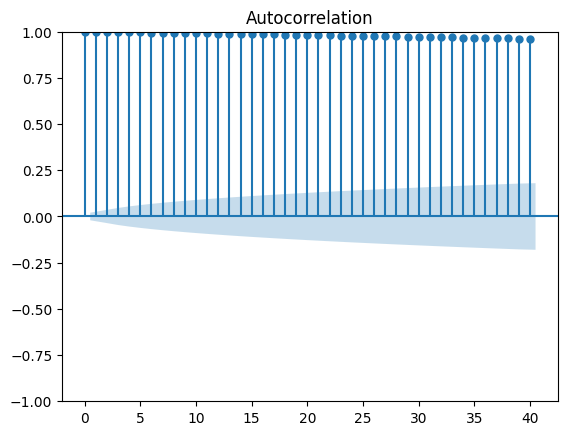

<Figure size 1200x600 with 0 Axes>

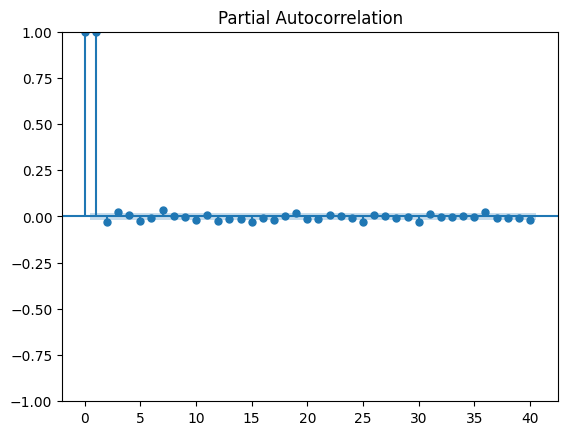

In [23]:
from scripts.change_point_analysis import autoCorrAndPartialAutoCorr
autoCorrAndPartialAutoCorr(data)

##### p=1 (based on PACF plot),
##### d=1 (data was non-stationary),
##### q=1 (based on ACF plot),

>> ## ARIMA model trend analysis

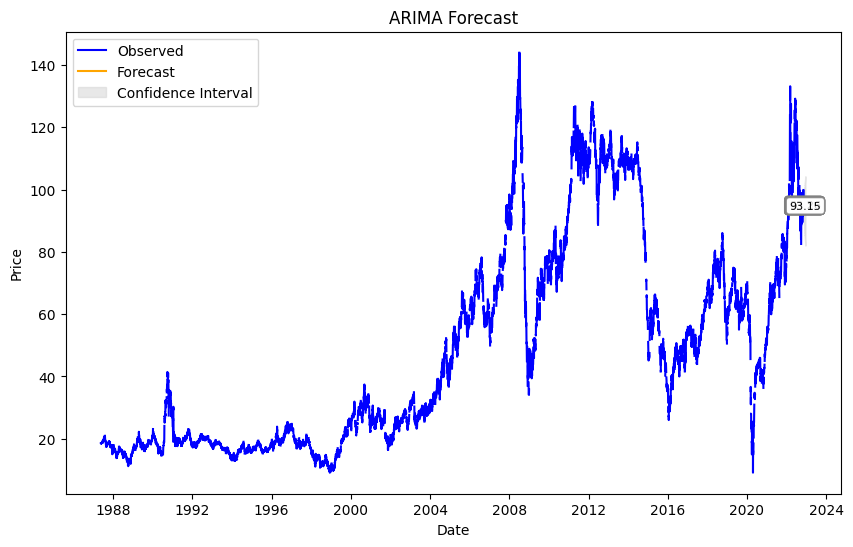

Forecasted Prices:

Date: 2022-11-15, Forecasted Price: 93.01
Date: 2022-11-16, Forecasted Price: 93.13
Date: 2022-11-17, Forecasted Price: 93.61
Date: 2022-11-18, Forecasted Price: 93.12
Date: 2022-11-19, Forecasted Price: 93.06
Date: 2022-11-20, Forecasted Price: 93.56
Date: 2022-11-21, Forecasted Price: 93.22
Date: 2022-11-22, Forecasted Price: 93.02
Date: 2022-11-23, Forecasted Price: 93.49
Date: 2022-11-24, Forecasted Price: 93.30
Date: 2022-11-25, Forecasted Price: 93.02
Date: 2022-11-26, Forecasted Price: 93.42
Date: 2022-11-27, Forecasted Price: 93.37
Date: 2022-11-28, Forecasted Price: 93.04
Date: 2022-11-29, Forecasted Price: 93.35
Date: 2022-11-30, Forecasted Price: 93.41
Date: 2022-12-01, Forecasted Price: 93.07
Date: 2022-12-02, Forecasted Price: 93.28
Date: 2022-12-03, Forecasted Price: 93.43
Date: 2022-12-04, Forecasted Price: 93.12
Date: 2022-12-05, Forecasted Price: 93.23
Date: 2022-12-06, Forecasted Price: 93.43
Date: 2022-12-07, Forecasted Price: 93.17
Date: 2022-12-

In [24]:
from scripts.plot import arima
df = data.copy()

arima(df)

>> ## GARCH Model Volatility Analysis 

In [25]:
data.head()

Date  Price  year  price_diff
0 1987-05-20  18.63  1987         NaN
1 1987-05-21  18.45  1987       -0.18
2 1987-05-22  18.55  1987        0.10
3 1987-05-25  18.60  1987        0.05
4 1987-05-26  18.63  1987        0.03

In [26]:
data = data.fillna(18.63)
data.isna().sum()

Date          0
Price         0
year          0
price_diff    0
dtype: int64

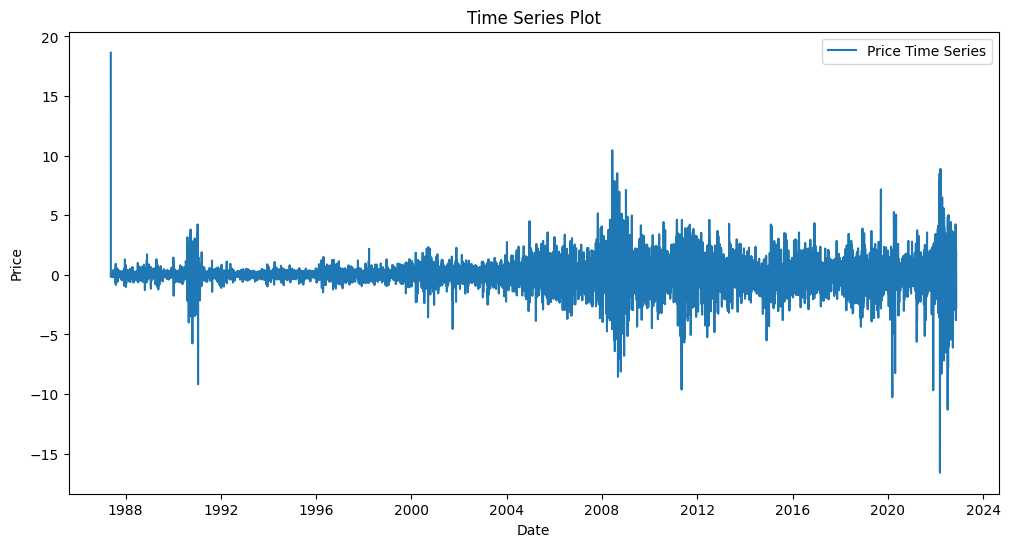

In [27]:
data = data.set_index('Date')
plt.figure(figsize=(12, 6))
plt.plot(data['price_diff'], label='Price Time Series')
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
data = data.reset_index()

In [28]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['price_diff'], order=(1, 1, 1))  
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                 9011
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -14665.382
Date:                Tue, 25 Feb 2025   AIC                          29336.763
Time:                        13:35:00   BIC                          29358.081
Sample:                             0   HQIC                         29344.017
                               - 9011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0248      0.006      4.355      0.000       0.014       0.036
ma.L1         -1.0000      0.004   -272.337      0.000      -1.007      -0.993
sigma2         1.5166      0.010    153.596      0.0

In [29]:
adf_result = adfuller(data['price_diff'].dropna())
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -15.554115577347016
p-value: 2.082008241753234e-28


>> ## GARCH

d:\week10\Change_point_analysis_and_statistical_modelling-\.week10\Lib\site-packages\arch\univariate\base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:             price_diff   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10558.6
Distribution:                  Normal   AIC:                           21125.1
Method:            Maximum Likelihood   BIC:                           21153.6
                                        No. Observations:                 9010
Date:                Tue, Feb 25 2025   Df Residuals:                     9009
Time:                        13:35:02   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.8334e-03  4.990e-03      0.969      0.333 

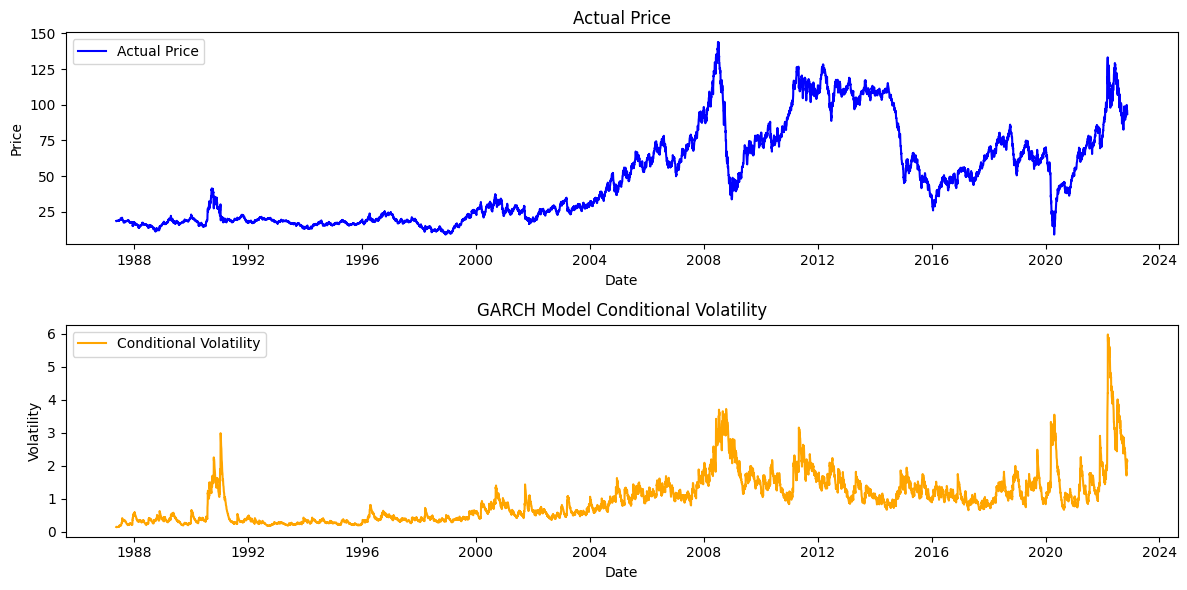

In [30]:
from scripts.plot import garch
garch(data)

>> ## With ARIMA

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             price_diff   No. Observations:                 9010
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14543.748
Date:                Tue, 25 Feb 2025   AIC                          29095.496
Time:                        13:35:03   BIC                          29123.920
Sample:                             0   HQIC                         29105.168
                               - 9010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0083      0.013      0.625      0.532      -0.018       0.034
ar.L1         -0.3416      0.160     -2.139      0.032      -0.655      -0.029
ma.L1          0.3701      0.15

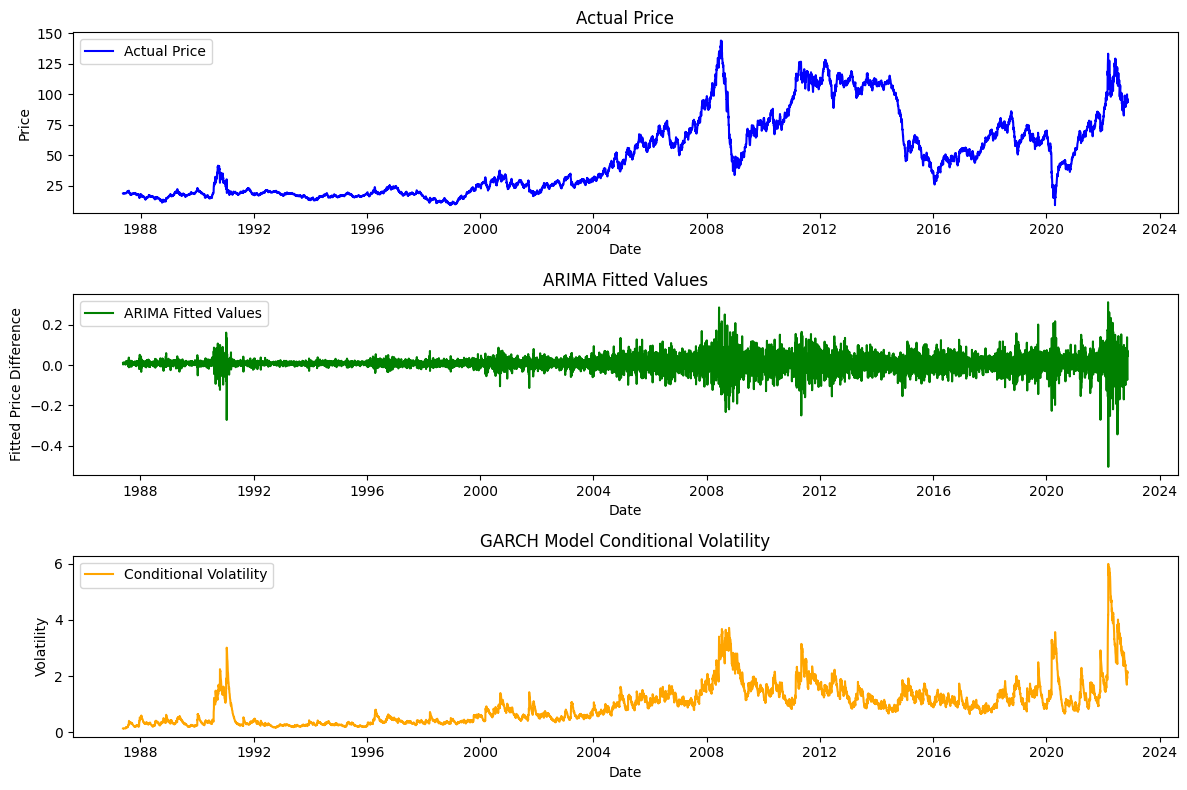

In [31]:
from scripts.plot import all_models
all_models(data)

>> ## LSTM Model for short term forecasting

In [32]:
OG_data = data.copy()

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - loss: 0.0417
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0021
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0022
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 0.0024
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - loss: 0.0021
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - loss: 0.0021
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0022
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 0.0021
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0022
Epoch 10/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0021
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


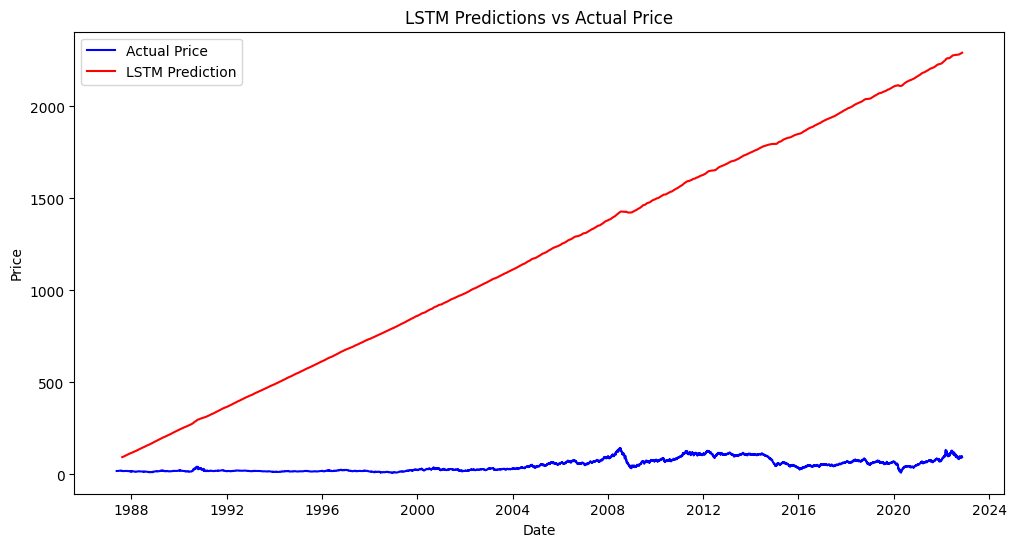

In [33]:
from scripts.plot import lstm
lstm(data)

>>> ### GDP Over Time For Countries

Type of er_df: <class 'wbdata.client.DataFrame'>


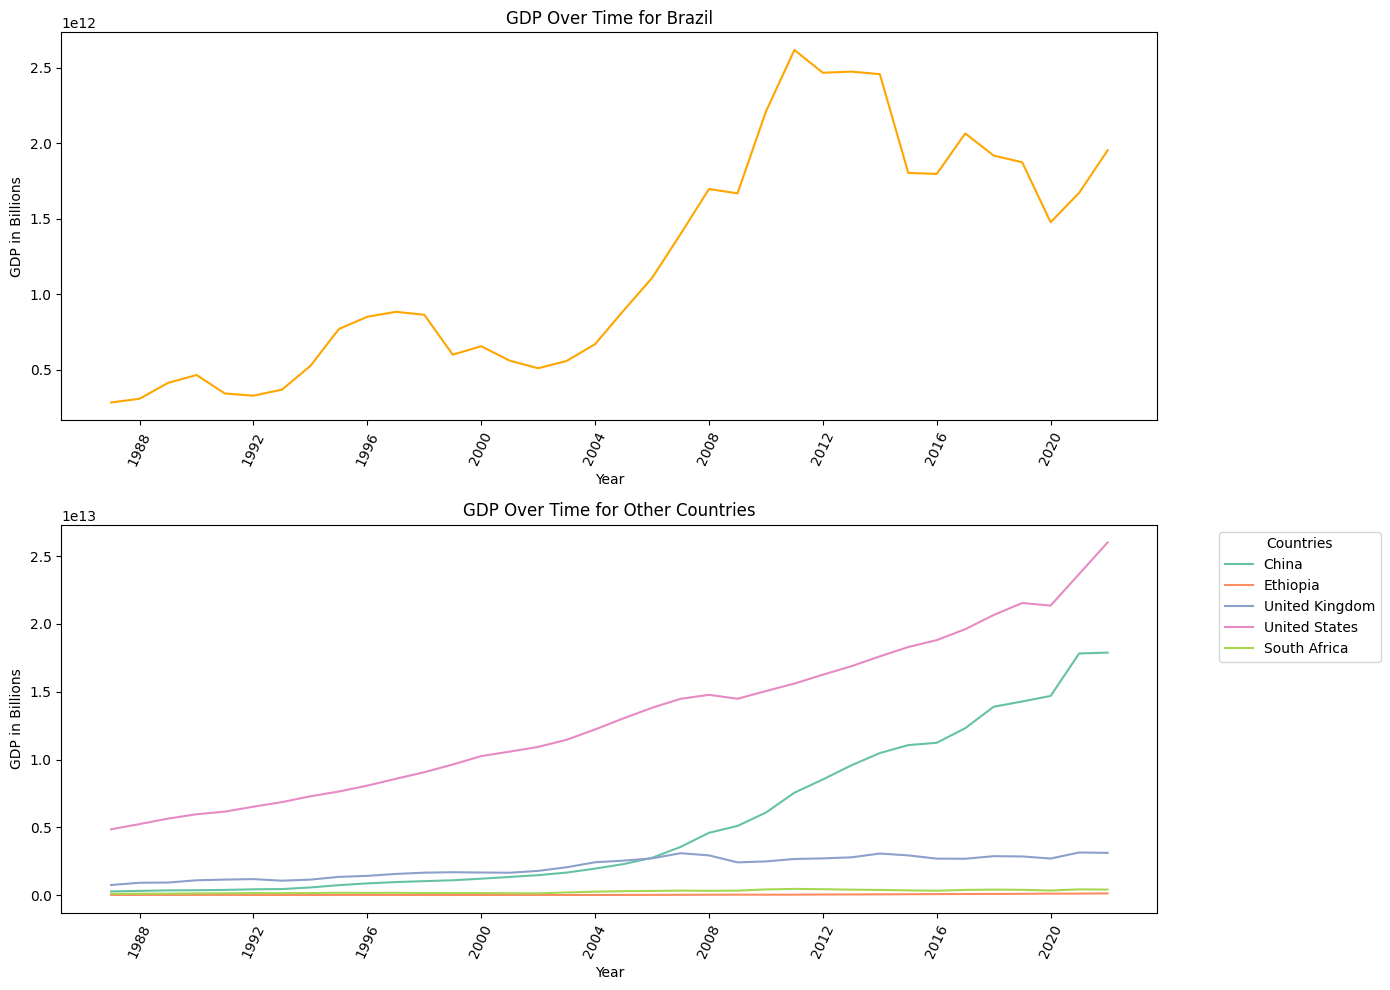

In [34]:
from scripts.additional_data import *
gdp_data = gdp_data(start_date,end_date)

>>> ### Inflation Over Time For Countries

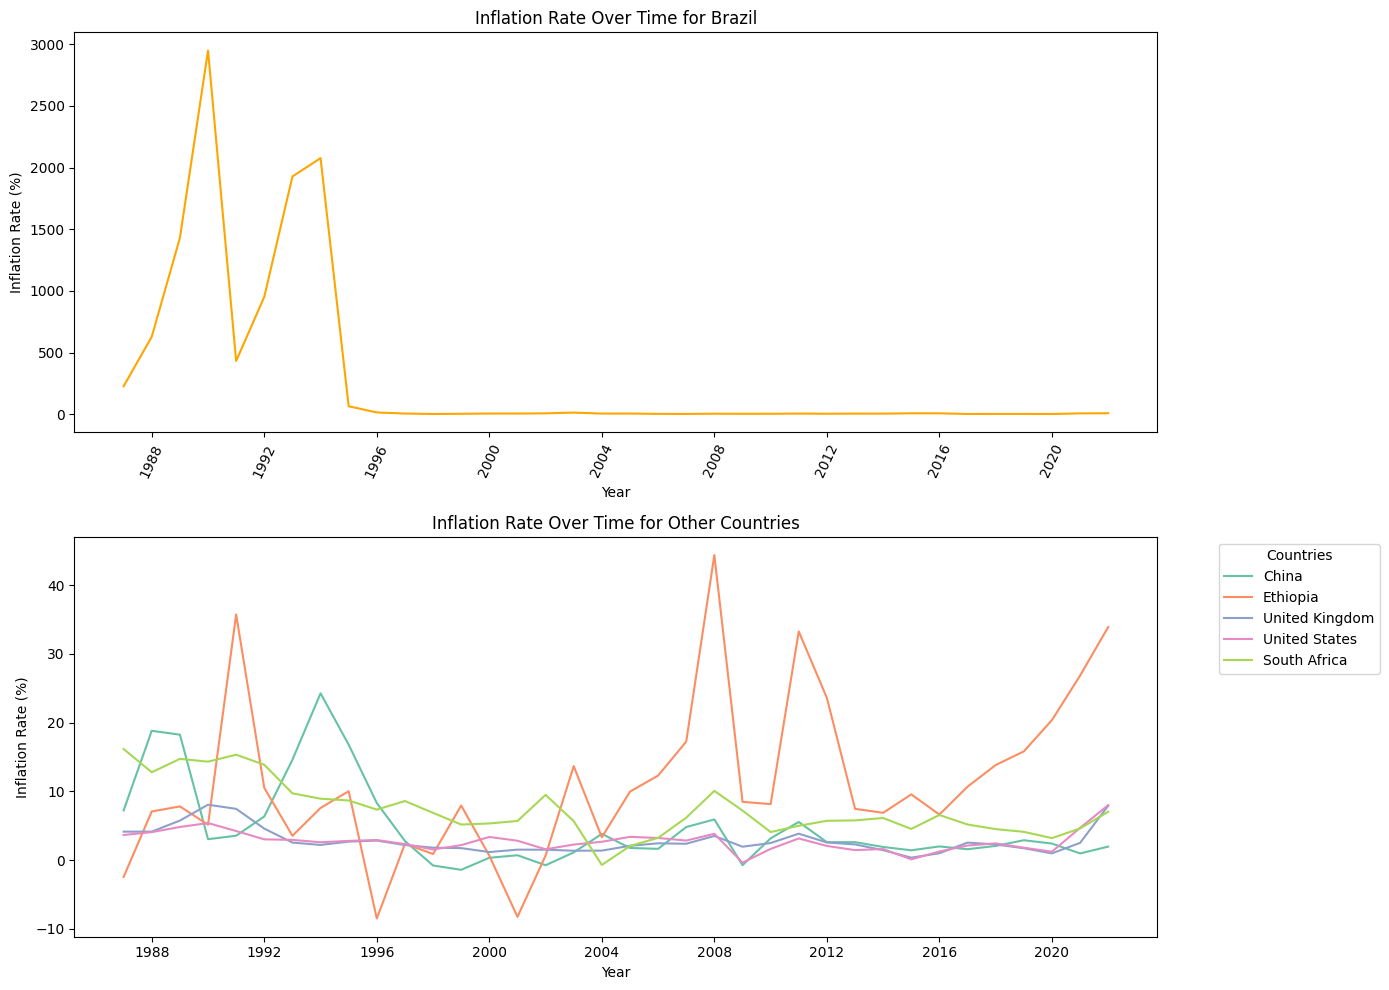

In [35]:
inflation_data = inflation_data(start_date,end_date)

>>> ### Unemployement Rates Over Time By Countries

Unemployment Data:
          country       date  Unemployment
1          Brazil 2022-01-01         9.231
2          Brazil 2021-01-01        13.158
3          Brazil 2020-01-01        13.697
4          Brazil 2019-01-01        11.936
5          Brazil 2018-01-01        12.329
..            ...        ...           ...
352  South Africa 1991-01-01        23.002
353  South Africa 1990-01-01           NaN
354  South Africa 1989-01-01           NaN
355  South Africa 1988-01-01           NaN
356  South Africa 1987-01-01           NaN

[216 rows x 3 columns]


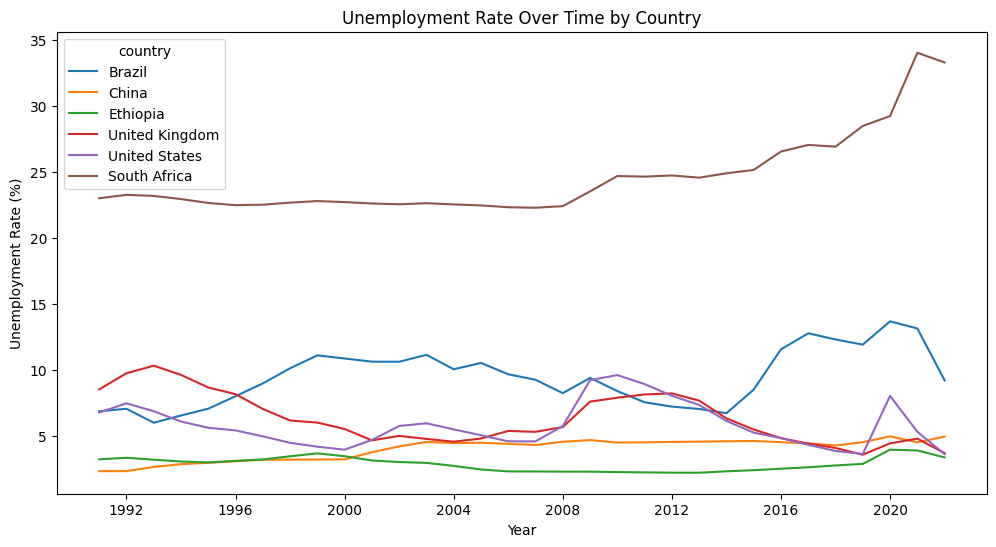

In [36]:
unemployment_data = unemployment_data()

>>> ### Exchange Rates Over Time by Country

In [37]:
exchange_rate_data = exchange_rate()

>>> ### Merge them

In [38]:
data = data.reset_index()

In [39]:
data = data.drop(columns=['date'])
data.head()

Date  Price  year  price_diff
0 1987-05-20  18.63  1987         NaN
1 1987-05-21  18.45  1987       -0.18
2 1987-05-22  18.55  1987        0.10
3 1987-05-25  18.60  1987        0.05
4 1987-05-26  18.63  1987        0.03

In [40]:
%load_ext autoreload
%autoreload 2


In [41]:
data_og = data.copy()

In [45]:
er_df = exchange_rate()
print("Inside notebook, er_df is:", er_df)
print("Type of er_df:", type(er_df))


Inside notebook, er_df is:           country       date  Exchange Rate
1          Brazil 2022-01-01       5.163970
2          Brazil 2021-01-01       5.394401
3          Brazil 2020-01-01       5.155179
4          Brazil 2019-01-01       3.944471
5          Brazil 2018-01-01       3.653825
..            ...        ...            ...
352  South Africa 1991-01-01       2.761315
353  South Africa 1990-01-01       2.587321
354  South Africa 1989-01-01       2.622677
355  South Africa 1988-01-01       2.273468
356  South Africa 1987-01-01       2.036033

[216 rows x 3 columns]
Type of er_df: <class 'wbdata.client.DataFrame'>


In [47]:
# Instead of passing the function, call it:
from scripts.additional_data import combine_all
er_df = exchange_rate()  # Should return a DataFrame
combined_data = combine_all(data, inflation_data, exchange_rate_data, gdp_data, unemployment_data)
print("Inside combine_all:")
print("Type of exchange_rate_data:", type(exchange_rate_data))
print("exchange_rate_data is:", exchange_rate_data)



Inside combine_all:
Type of exchange_rate_data: <class 'wbdata.client.DataFrame'>
exchange_rate_data is:           country       date  Exchange Rate  year
1          Brazil 2022-01-01       5.163970  2022
2          Brazil 2021-01-01       5.394401  2021
3          Brazil 2020-01-01       5.155179  2020
4          Brazil 2019-01-01       3.944471  2019
5          Brazil 2018-01-01       3.653825  2018
..            ...        ...            ...   ...
352  South Africa 1991-01-01       2.761315  1991
353  South Africa 1990-01-01       2.587321  1990
354  South Africa 1989-01-01       2.622677  1989
355  South Africa 1988-01-01       2.273468  1988
356  South Africa 1987-01-01       2.036033  1987

[216 rows x 4 columns]


In [49]:
combined_data = combine_all(data, inflation_data, er_df, gdp_data, unemployment_data)
print(combined_data.head())


          Date  Price  price_diff           GDP   Inflation  Unemployment  \
0   1987-05-20  18.63         NaN  2.830568e+11  228.336163           NaN   
868 1987-05-20  18.63         NaN  4.855215e+12  228.336163           NaN   
867 1987-05-20  18.63         NaN  4.855215e+12  228.336163           NaN   
866 1987-05-20  18.63         NaN  4.855215e+12  228.336163           NaN   
865 1987-05-20  18.63         NaN  4.855215e+12  228.336163           NaN   

     Exchange Rate  
0     1.697631e-08  
868   1.000000e+00  
867   6.119265e-01  
866   2.070000e+00  
865   3.722100e+00  


In [50]:
combined_data.isna().sum()

Date                   0
Price                  0
price_diff          1296
GDP                    0
Inflation              0
Unemployment     1198800
Exchange Rate          0
dtype: int64

In [51]:
row_count = combined_data.shape[0]

print("Number of rows before removing duplicates:", row_count)
combined_data = combined_data.drop_duplicates(subset='Date', keep='first')

row_count_after = combined_data.shape[0]

print("Number of rows after removing duplicates:", row_count_after)


Number of rows before removing duplicates: 11678256
Number of rows after removing duplicates: 9011


In [52]:
combined_data = combined_data.fillna(method='ffill')

for column in ['Inflation', 'Unemployment', 'Exchange Rate']:
    combined_data[f'{column}_missing'] = combined_data[column].isna().astype(int)

# Step 3: Perform backfill to fill in the first missing values from the earliest available year
combined_data = combined_data.fillna(method='bfill')

In [56]:
combined_data.head(20)

Date  Price  price_diff           GDP   Inflation  Unemployment  \
0     1987-05-20  18.63       -0.18  2.830568e+11  228.336163           6.8   
2164  1987-05-21  18.45       -0.18  4.855215e+12  228.336163           6.8   
3460  1987-05-22  18.55        0.10  4.855215e+12  228.336163           6.8   
4756  1987-05-25  18.60        0.05  4.855215e+12  228.336163           6.8   
6053  1987-05-26  18.63        0.03  4.855215e+12  228.336163           6.8   
7348  1987-05-27  18.60       -0.03  4.855215e+12  228.336163           6.8   
8643  1987-05-28  18.60        0.00  4.855215e+12  228.336163           6.8   
9939  1987-05-29  18.58       -0.02  4.855215e+12  228.336163           6.8   
11236 1987-06-01  18.65        0.07  4.855215e+12  228.336163           6.8   
12532 1987-06-02  18.68        0.03  4.855215e+12  228.336163           6.8   
13829 1987-06-03  18.75        0.07  4.855215e+12  228.336163           6.8   
15125 1987-06-04  18.78        0.03  4.855215e+12  228.336163           6.8   
16418 1987-06-05  18.65       -0.13  4.855215e+12  228.336163           6.8   
17716 1987-06-08  18.75        0.10  4.855215e+12  228.336163           6.8   
19010 1987-06-09  18.78        0.03  4.855215e+12  228.336163           6.8   
20306 1987-06-10  18.78        0.00  4.855215e+12  228.336163           6.8   
21603 1987-06-11  18.68       -0.10  4.855215e+12  228.336163           6.8   
22900 1987-06-12  18.78        0.10  4.855215e+12  228.336163           6.8   
24192 1987-06-16  18.90        0.12  4.855215e+12  228.336163           6.8   
25493 1987-06-17  19.03        0.13  4.855215e+12  228.336163           6.8   

       Exchange Rate  Inflation_missing  Unemployment_missing  \
0       1.697631e-08                  0                     1   
2164    1.000000e+00                  0                     1   
3460    1.000000e+00                  0                     1   
4756    1.000000e+00                  0                     1   
6053    2.036033e+00                  0                     1   
7348    1.000000e+00                  0                     1   
8643    6.119265e-01                  0                     1   
9939    6.119265e-01                  0                     1   
11236   1.000000e+00                  0                     1   
12532   1.000000e+00                  0                     1   
13829   2.036033e+00                  0                     1   
15125   2.036033e+00                  0                     1   
16418   2.070000e+00                  0                     1   
17716   1.000000e+00                  0                     1   
19010   2.070000e+00                  0                     1   
20306   2.070000e+00                  0                     1   
21603   6.119265e-01                  0                     1   
22900   1.000000e+00                  0                     1   
24192   1.697631e-08                  0                     1   
25493   2.036033e+00                  0                     1   

       Exchange Rate_missing  
0                          0  
2164                       0  
3460                       0  
4756                       0  
6053                       0  
7348                       0  
8643                       0  
9939                       0  
11236                      0  
12532                      0  
13829                      0  
15125                      0  
16418                      0  
17716                      0  
19010                      0  
20306                      0  
21603                      0  
22900                      0  
24192                      0  
25493                      0

>> ## Correlation of GDP with oil Prices

Correlation between Brent Oil Prices and GDP: 0.69
Correlation between Brent Oil Prices and Inflation: -0.38
Correlation between Brent Oil Prices and Unemployment: 0.03
Correlation between Brent Oil Prices and Exchange Rate: 0.29


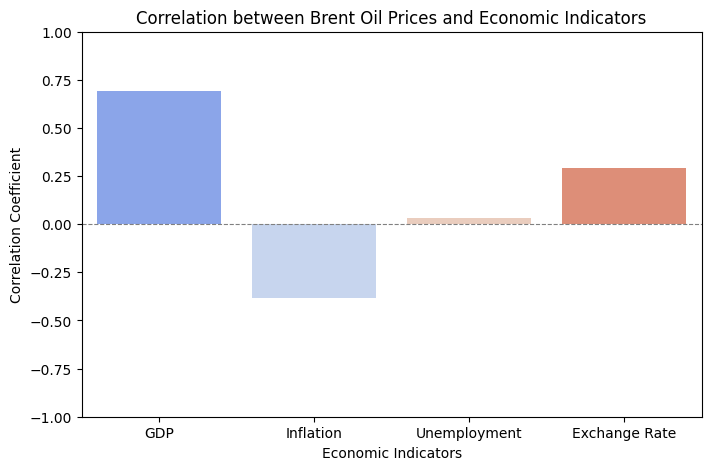

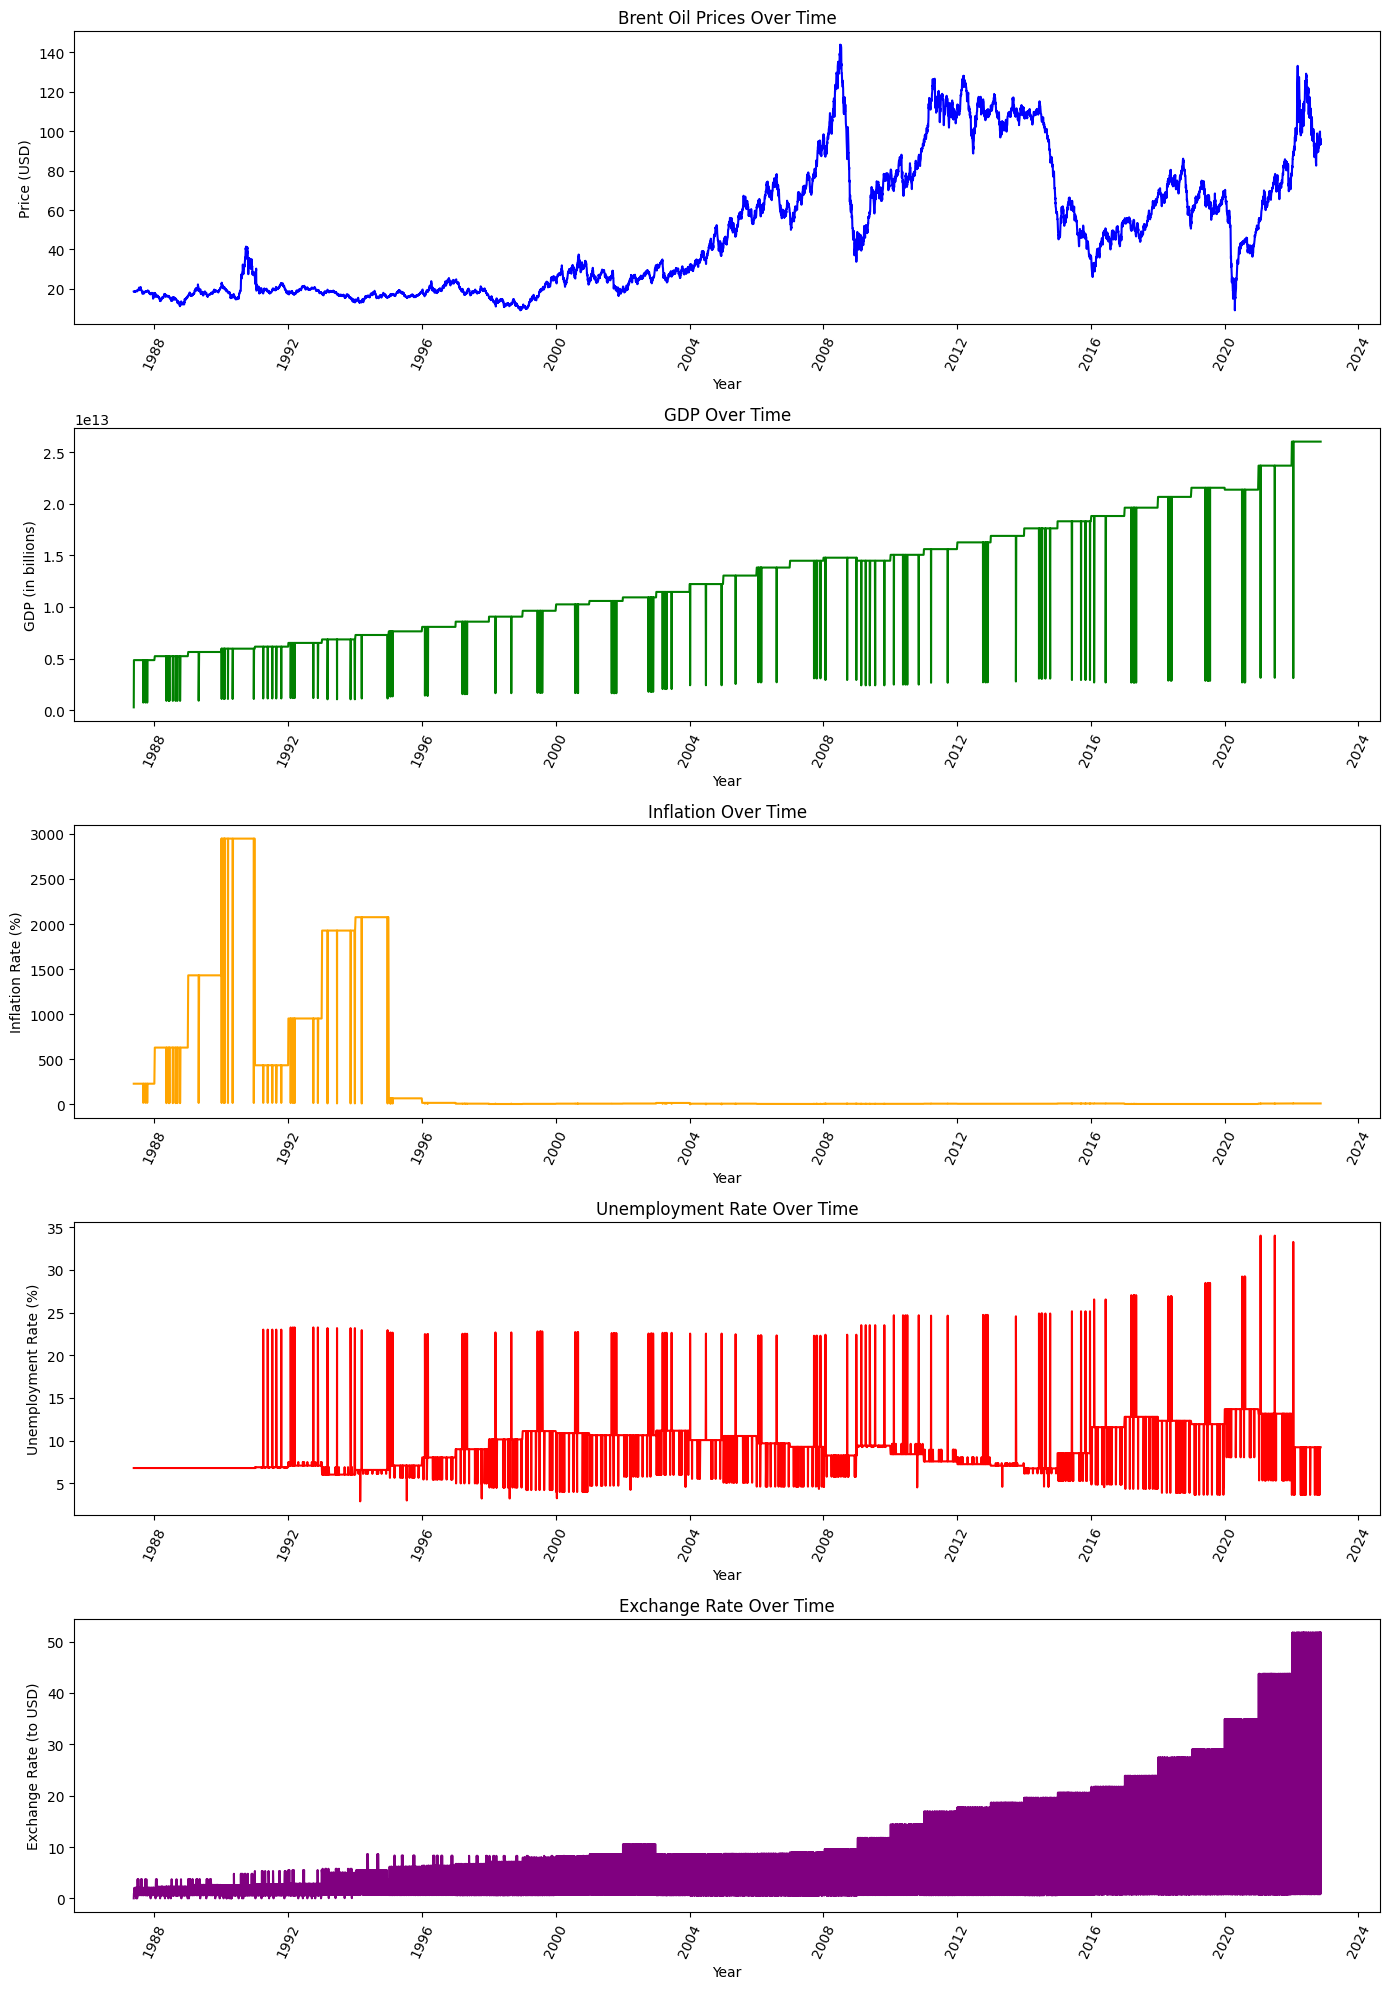

In [57]:
correlations(combined_data)

In [58]:
data_og = data.copy()

>> ## Technological Changes

In [59]:
import requests
import pandas as pd

API_KEY = 'TfbBX8D8Fq9NIZuZ7luWDz6Uno7hNOmTnNN05CDg'
# API URL and parameters
url = "https://api.eia.gov/v2/crude-oil-imports/data/"
params = {
    "frequency": "monthly",
    "data[0]": "quantity",
    "start": "2009-01",
    "end": "2022-08",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers to include the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert the response to JSON
    data = response.json()
    
    # Extract the data portion
    if 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Convert to a DataFrame
        df_oil_imports = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
        print(df_oil_imports.head())  # Show the first few rows
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")

    period originId       originName originType originTypeName destinationId  \
0  2022-08   CTY_UK   United Kingdom        CTY        Country         PS_CA   
1  2022-08   REG_CA  Canada (Region)        REG         Region        RF_502   
2  2022-08   REG_CA  Canada (Region)        REG         Region        RF_393   
3  2022-08   REG_CA  Canada (Region)        REG         Region        RF_288   
4  2022-08    OPN_N         Non-OPEC        OPN  OPEC/non-OPEC        RF_502   

                                     destinationName destinationType  \
0                                         California              PS   
1  VALERO REFINING CO TEXAS LP / HOUSTON REFINERY...              RF   
2               PHILLIPS 66 / BILLINGS REFINERY / MT              RF   
3                       LIMA REFINING CO / LIMA / OH              RF   
4  VALERO REFINING CO TEXAS LP / HOUSTON REFINERY...              RF   

  destinationTypeName gradeId    gradeName quantity    quantity-units  
0          Por

In [60]:
df_oil_imports.head()

period originId       originName originType originTypeName destinationId  \
0  2022-08   CTY_UK   United Kingdom        CTY        Country         PS_CA   
1  2022-08   REG_CA  Canada (Region)        REG         Region        RF_502   
2  2022-08   REG_CA  Canada (Region)        REG         Region        RF_393   
3  2022-08   REG_CA  Canada (Region)        REG         Region        RF_288   
4  2022-08    OPN_N         Non-OPEC        OPN  OPEC/non-OPEC        RF_502   

                                     destinationName destinationType  \
0                                         California              PS   
1  VALERO REFINING CO TEXAS LP / HOUSTON REFINERY...              RF   
2               PHILLIPS 66 / BILLINGS REFINERY / MT              RF   
3                       LIMA REFINING CO / LIMA / OH              RF   
4  VALERO REFINING CO TEXAS LP / HOUSTON REFINERY...              RF   

  destinationTypeName gradeId    gradeName quantity    quantity-units  
0          Port State     HSW  Heavy Sweet      499  thousand barrels  
1            Refinery     HSO   Heavy Sour      249  thousand barrels  
2            Refinery     MED       Medium      305  thousand barrels  
3            Refinery     MED       Medium       75  thousand barrels  
4            Refinery     HSO   Heavy Sour      249  thousand barrels

>> ## Renewable Energy

In [61]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'TfbBX8D8Fq9NIZuZ7luWDz6Uno7hNOmTnNN05CDg'

# API URL and parameters
url = "https://api.eia.gov/v2/steo/data/"
params = {
    "frequency": "monthly",
    "data[0]": "value",
    "facets": {},
    "start": "1987-01",
    "end": "2022-11",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        renewable_energy = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")

In [62]:
renewable_energy.head()

period    seriesId                                  seriesDescription  \
0  2022-11    EXRCP_US  Retail Sales of Electricity in Residential Sec...   
1  2022-11       NWDAP                       Appalachia New Wells Drilled   
2  2022-11  NGEPGEN_TX  Electric power sector net generation from natu...   
3  2022-11     OBNIPUS                         Other Biofuels Net Imports   
4  2022-11  OGEPGEN_NY  Electric power sector net generation from othe...   

          value                           unit  
0   3438.402591  million kilowatthours per day  
1            98                           None  
2  11.997335792          billion kilowatthours  
3             0        million barrels per day  
4             0          billion kilowatthours

>> ## Coal Consumption

In [63]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'TfbBX8D8Fq9NIZuZ7luWDz6Uno7hNOmTnNN05CDg'

# API URL and parameters
url = "https://api.eia.gov/v2/coal/consumption-and-quality/data/"
params = {
    "frequency": "quarterly",
    "data[0]": "ash-content",
    "data[1]": "consumption",
    "data[2]": "heat-content",
    "data[3]": "price",
    "data[4]": "receipts",
    "data[5]": "stocks",
    "data[6]": "sulfur-content",
    "facets": {},
    "start": "2000-Q1",
    "end": "2022-Q3",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        coal_cons = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


In [64]:
coal_cons.head()

period location stateDescription sector sectorDescription ash-content  \
0  2022-Q3       81  Middle Atlantic      1  Electric Utility        None   
1  2022-Q3       WY          Wyoming     98    Electric Power        7.27   
2  2022-Q3       WV    West Virginia     98    Electric Power       10.92   
3  2022-Q3       WI        Wisconsin     98    Electric Power        5.13   
4  2022-Q3       WA       Washington     98    Electric Power        8.75   

  consumption heat-content  price receipts stocks sulfur-content  \
0           0         None   None     None   None           None   
1     6261685    17.559932   None  5243039   None            .41   
2     6176330    24.740472   None  5931811   None           3.28   
3     3619609    17.877569  45.25  3430465   None            .43   
4      771067    17.093282   None   868665   None            .37   

               ash-content-units consumption-units  \
0  average ash percent by weight        short tons   
1  average ash percent by weight        short tons   
2  average ash percent by weight        short tons   
3  average ash percent by weight        short tons   
4  average ash percent by weight        short tons   

                 heat-content-units            price-units receipts-units  \
0  average sulfur percent by weight  dollars per short ton     short tons   
1  average sulfur percent by weight  dollars per short ton     short tons   
2  average sulfur percent by weight  dollars per short ton     short tons   
3  average sulfur percent by weight  dollars per short ton     short tons   
4  average sulfur percent by weight  dollars per short ton     short tons   

  stocks-units              sulfur-content-units  
0   short tons  average sulfur percent by weight  
1   short tons  average sulfur percent by weight  
2   short tons  average sulfur percent by weight  
3   short tons  average sulfur percent by weight  
4   short tons  average sulfur percent by weight

>> ## Natural Gas

In [65]:
import requests
import pandas as pd

# API Key (replace with your own if different)
API_KEY = 'TfbBX8D8Fq9NIZuZ7luWDz6Uno7hNOmTnNN05CDg'

# API URL and parameters
url = "https://api.eia.gov/v2/natural-gas/pri/rescom/data/"
params = {
    "frequency": "monthly",
    "data[0]": "value",
    "facets": {},
    "start": "1989-01",
    "end": "2022-08",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000
}

# Set the headers with the API key
headers = {
    'X-Api-Key': API_KEY
}

# Make the GET request
response = requests.get(url, params=params, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    # Convert response to JSON
    data = response.json()
    
    # Extract 'data' field from JSON, which contains the import data
    if 'response' in data and 'data' in data['response']:
        oil_imports = data['response']['data']
        
        # Create a DataFrame from the data
        natural_gas = pd.DataFrame(oil_imports)
        
        # Display the DataFrame
    else:
        print("No data found in the response.")
else:
    print(f"Error: {response.status_code} - {response.text}")


In [66]:
natural_gas.head()

period duoarea area-name product product-name process  \
0  2022-07     SDC    USA-DC    EPG0  Natural Gas     PCS   
1  2022-07     SNJ    USA-NJ    EPG0  Natural Gas     PCS   
2  2022-07     SNJ    USA-NJ    EPG0  Natural Gas     PRS   
3  2022-07     SVA    USA-VA    EPG0  Natural Gas     PCS   
4  2022-07     SNY  NEW YORK    EPG0  Natural Gas     PCS   

                               process-name    series  \
0     Price Delivered to Commercial Sectors  N3020DC3   
1     Price Delivered to Commercial Sectors  N3020NJ3   
2  Price Delivered to Residential Consumers  N3010NJ3   
3     Price Delivered to Commercial Sectors  N3020VA3   
4     Price Delivered to Commercial Sectors  N3020NY3   

                                  series-description  value  units  
0  District of Columbia Price of Natural Gas Sold...  18.05  $/MCF  
1  New Jersey Price of Natural Gas Sold to Commer...  14.85  $/MCF  
2  New Jersey Price of Natural Gas Delivered to R...  16.31  $/MCF  
3  Virginia Price of Natural Gas Sold to Commerci...  13.77  $/MCF  
4  New York Price of Natural Gas Sold to Commerci...  10.34  $/MCF

In [67]:
data_og.head()

Date  Price  year  price_diff
0 1987-05-20  18.63  1987         NaN
1 1987-05-21  18.45  1987       -0.18
2 1987-05-22  18.55  1987        0.10
3 1987-05-25  18.60  1987        0.05
4 1987-05-26  18.63  1987        0.03

In [68]:
import pandas as pd

data_og['Date'] = pd.to_datetime(data_og['Date'])
natural_gas['period'] = pd.to_datetime(natural_gas['period'])
coal_cons['period'] = pd.to_datetime(coal_cons['period'])
renewable_energy['period'] = pd.to_datetime(renewable_energy['period'])
df_oil_imports['period'] = pd.to_datetime(df_oil_imports['period'])

In [69]:
natural_gas = natural_gas[['period', 'area-name', 'product-name', 'series-description', 'value', 'units']]
coal_consumption = coal_cons[['period', 'location', 'sectorDescription', 'consumption', 'price', 'consumption-units', 'price-units']]
renewable_energy = renewable_energy[['period', 'seriesDescription', 'value', 'unit']]
df_oil_imports = df_oil_imports[['period', 'originName', 'gradeName', 'quantity', 'quantity-units']]

In [70]:
data_og = data_og.reset_index()
natural_gas = natural_gas.reset_index()
coal_consumption = coal_consumption.reset_index()
renewable_energy = renewable_energy.reset_index()
df_oil_imports = df_oil_imports.reset_index()

In [71]:
data_og.set_index('Date', inplace=True)
natural_gas.set_index('period', inplace=True)
coal_consumption.set_index('period', inplace=True)
renewable_energy.set_index('period', inplace=True)
df_oil_imports.set_index('period', inplace=True)

In [72]:
print(natural_gas.dtypes)
print(coal_consumption.dtypes)
print(renewable_energy.dtypes)
print(df_oil_imports.dtypes)


index                  int64
area-name             object
product-name          object
series-description    object
value                 object
units                 object
dtype: object
index                 int64
location             object
sectorDescription    object
consumption          object
price                object
consumption-units    object
price-units          object
dtype: object
index                 int64
seriesDescription    object
value                object
unit                 object
dtype: object
index              int64
originName        object
gradeName         object
quantity          object
quantity-units    object
dtype: object


In [73]:
natural_gas['value'] = pd.to_numeric(natural_gas['value'], errors='coerce')
coal_consumption['consumption'] = pd.to_numeric(coal_consumption['consumption'], errors='coerce')
renewable_energy['value'] = pd.to_numeric(renewable_energy['value'], errors='coerce')
df_oil_imports['quantity'] = pd.to_numeric(df_oil_imports['quantity'], errors='coerce')

natural_gas['value_x'] = natural_gas['value'].fillna(natural_gas['value'].median())
coal_consumption['consumption'] = coal_consumption['consumption'].fillna(coal_consumption['consumption'].median())
renewable_energy['value_y'] = renewable_energy['value'].fillna(renewable_energy['value'].median())
df_oil_imports['quantity'] = df_oil_imports['quantity'].fillna(df_oil_imports['quantity'].median())


natural_gas_monthly = natural_gas.resample('M').mean(numeric_only=True)
coal_consumption_monthly = coal_consumption.resample('M').sum(numeric_only=True)
renewable_energy_monthly = renewable_energy.resample('M').sum(numeric_only=True)
oil_imports_monthly = df_oil_imports.resample('M').sum(numeric_only=True)

In [74]:
common_date_range = pd.date_range(start='2009-01', end='2022-08', freq='M')

In [75]:
data_og = data_og.reindex(common_date_range)
natural_gas_monthly = natural_gas_monthly.reindex(common_date_range)
coal_consumption_monthly = coal_consumption_monthly.reindex(common_date_range)
renewable_energy_monthly = renewable_energy_monthly.reindex(common_date_range)
oil_imports_monthly = oil_imports_monthly.reindex(common_date_range)


In [76]:
coal_consumption.head()

index location sectorDescription  consumption  price  \
period                                                             
2022-07-01      0       81  Electric Utility          0.0   None   
2022-07-01      1       WY    Electric Power    6261685.0   None   
2022-07-01      2       WV    Electric Power    6176330.0   None   
2022-07-01      3       WI    Electric Power    3619609.0  45.25   
2022-07-01      4       WA    Electric Power     771067.0   None   

           consumption-units            price-units  
period                                               
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton  
2022-07-01        short tons  dollars per short ton

In [77]:
combined_df = pd.concat([data_og, natural_gas_monthly, coal_consumption_monthly, renewable_energy_monthly, oil_imports_monthly], axis=1)

In [78]:
combined_df.columns

Index(['index', 'Price', 'year', 'price_diff', 'index', 'value', 'value_x',
       'index', 'consumption', 'index', 'value', 'value_y', 'index',
       'quantity'],
      dtype='object')

In [79]:
combined_df.rename(columns={
    'Price': 'Oil_Price',
    'value_x': 'Natural_Gas_Value',
    'consumption': 'Coal_Consumption',
    'value_y': 'Renewable_Energy_Value',
    'quantity': 'Oil_Imports_Quantity'
}, inplace=True)


In [80]:
combined_df['Oil_Price_Diff'] = combined_df['Oil_Price'].pct_change() * 100


In [81]:
print(combined_df.columns)


Index(['index', 'Oil_Price', 'year', 'price_diff', 'index', 'value',
       'Natural_Gas_Value', 'index', 'Coal_Consumption', 'index', 'value',
       'Renewable_Energy_Value', 'index', 'Oil_Imports_Quantity',
       'Oil_Price_Diff'],
      dtype='object')


In [82]:
combined_df['Natural_Gas_Rolling'] = combined_df.get('Natural_Gas_Value', pd.Series()).rolling(window=3).mean()


In [83]:
correlation_matrix = combined_df.corr()
oil_price_correlation = correlation_matrix['Oil_Price']


In [84]:
combined_df.head(0)

Empty DataFrame
Columns: [index, Oil_Price, year, price_diff, index, value, Natural_Gas_Value, index, Coal_Consumption, index, value, Renewable_Energy_Value, index, Oil_Imports_Quantity, Oil_Price_Diff, Natural_Gas_Rolling]
Index: []

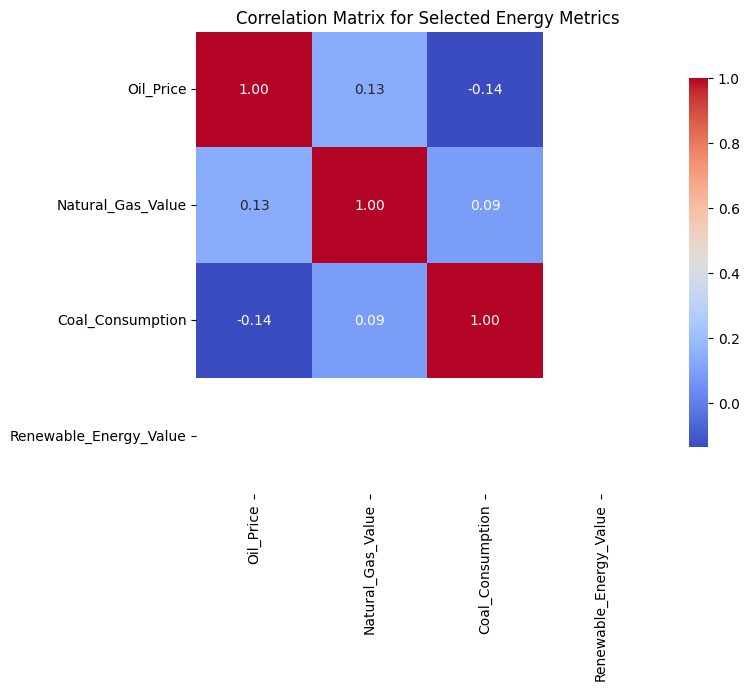

In [85]:
columns_of_interest = ['Oil_Price', 'Natural_Gas_Value', 'Coal_Consumption', 'Renewable_Energy_Value']
correlation_matrix = combined_df[columns_of_interest].corr()

plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix for Selected Energy Metrics')
plt.show()

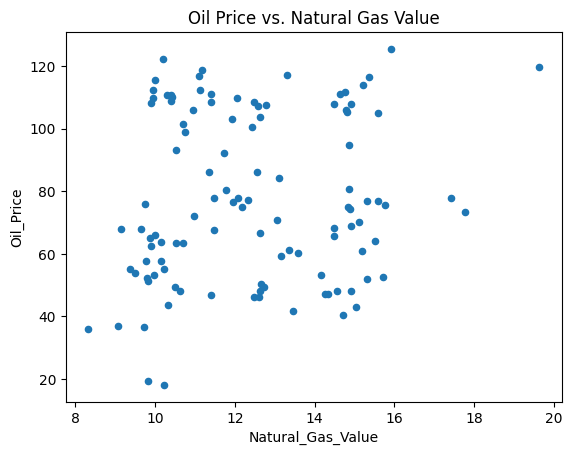

In [86]:
combined_df.plot(kind='scatter', x='Natural_Gas_Value', y='Oil_Price', title='Oil Price vs. Natural Gas Value')
plt.show()

In [88]:
combined_df.to_csv('./docs/technological_data.csv')

>>> ### Data Preprocess

In [91]:
print(combined_data.isna().sum())

combined_data[['GDP', 'Unemployment']] = combined_data[['GDP', 'Unemployment']].fillna(
    combined_data[['GDP', 'Unemployment']].median()
)

print(combined_data.isna().sum())

combined_data.head(20)

Date                     0
Price                    0
price_diff               0
GDP                      0
Inflation                0
Unemployment             0
Exchange Rate            0
Inflation_missing        0
Unemployment_missing     0
Exchange Rate_missing    0
dtype: int64
Date                     0
Price                    0
price_diff               0
GDP                      0
Inflation                0
Unemployment             0
Exchange Rate            0
Inflation_missing        0
Unemployment_missing     0
Exchange Rate_missing    0
dtype: int64


Date  Price  price_diff           GDP   Inflation  Unemployment  \
0     1987-05-20  18.63       -0.18  2.830568e+11  228.336163           6.8   
2164  1987-05-21  18.45       -0.18  4.855215e+12  228.336163           6.8   
3460  1987-05-22  18.55        0.10  4.855215e+12  228.336163           6.8   
4756  1987-05-25  18.60        0.05  4.855215e+12  228.336163           6.8   
6053  1987-05-26  18.63        0.03  4.855215e+12  228.336163           6.8   
7348  1987-05-27  18.60       -0.03  4.855215e+12  228.336163           6.8   
8643  1987-05-28  18.60        0.00  4.855215e+12  228.336163           6.8   
9939  1987-05-29  18.58       -0.02  4.855215e+12  228.336163           6.8   
11236 1987-06-01  18.65        0.07  4.855215e+12  228.336163           6.8   
12532 1987-06-02  18.68        0.03  4.855215e+12  228.336163           6.8   
13829 1987-06-03  18.75        0.07  4.855215e+12  228.336163           6.8   
15125 1987-06-04  18.78        0.03  4.855215e+12  228.336163           6.8   
16418 1987-06-05  18.65       -0.13  4.855215e+12  228.336163           6.8   
17716 1987-06-08  18.75        0.10  4.855215e+12  228.336163           6.8   
19010 1987-06-09  18.78        0.03  4.855215e+12  228.336163           6.8   
20306 1987-06-10  18.78        0.00  4.855215e+12  228.336163           6.8   
21603 1987-06-11  18.68       -0.10  4.855215e+12  228.336163           6.8   
22900 1987-06-12  18.78        0.10  4.855215e+12  228.336163           6.8   
24192 1987-06-16  18.90        0.12  4.855215e+12  228.336163           6.8   
25493 1987-06-17  19.03        0.13  4.855215e+12  228.336163           6.8   

       Exchange Rate  Inflation_missing  Unemployment_missing  \
0       1.697631e-08                  0                     1   
2164    1.000000e+00                  0                     1   
3460    1.000000e+00                  0                     1   
4756    1.000000e+00                  0                     1   
6053    2.036033e+00                  0                     1   
7348    1.000000e+00                  0                     1   
8643    6.119265e-01                  0                     1   
9939    6.119265e-01                  0                     1   
11236   1.000000e+00                  0                     1   
12532   1.000000e+00                  0                     1   
13829   2.036033e+00                  0                     1   
15125   2.036033e+00                  0                     1   
16418   2.070000e+00                  0                     1   
17716   1.000000e+00                  0                     1   
19010   2.070000e+00                  0                     1   
20306   2.070000e+00                  0                     1   
21603   6.119265e-01                  0                     1   
22900   1.000000e+00                  0                     1   
24192   1.697631e-08                  0                     1   
25493   2.036033e+00                  0                     1   

       Exchange Rate_missing  
0                          0  
2164                       0  
3460                       0  
4756                       0  
6053                       0  
7348                       0  
8643                       0  
9939                       0  
11236                      0  
12532                      0  
13829                      0  
15125                      0  
16418                      0  
17716                      0  
19010                      0  
20306                      0  
21603                      0  
22900                      0  
24192                      0  
25493                      0

>>> ### EDA

In [92]:
combined_data.head()

Date  Price  price_diff           GDP   Inflation  Unemployment  \
0    1987-05-20  18.63       -0.18  2.830568e+11  228.336163           6.8   
2164 1987-05-21  18.45       -0.18  4.855215e+12  228.336163           6.8   
3460 1987-05-22  18.55        0.10  4.855215e+12  228.336163           6.8   
4756 1987-05-25  18.60        0.05  4.855215e+12  228.336163           6.8   
6053 1987-05-26  18.63        0.03  4.855215e+12  228.336163           6.8   

      Exchange Rate  Inflation_missing  Unemployment_missing  \
0      1.697631e-08                  0                     1   
2164   1.000000e+00                  0                     1   
3460   1.000000e+00                  0                     1   
4756   1.000000e+00                  0                     1   
6053   2.036033e+00                  0                     1   

      Exchange Rate_missing  
0                         0  
2164                      0  
3460                      0  
4756                      0  
6053                      0

>> ## VAR for Multivariate Analysis

In [93]:
combined_data.head()

Date  Price  price_diff           GDP   Inflation  Unemployment  \
0    1987-05-20  18.63       -0.18  2.830568e+11  228.336163           6.8   
2164 1987-05-21  18.45       -0.18  4.855215e+12  228.336163           6.8   
3460 1987-05-22  18.55        0.10  4.855215e+12  228.336163           6.8   
4756 1987-05-25  18.60        0.05  4.855215e+12  228.336163           6.8   
6053 1987-05-26  18.63        0.03  4.855215e+12  228.336163           6.8   

      Exchange Rate  Inflation_missing  Unemployment_missing  \
0      1.697631e-08                  0                     1   
2164   1.000000e+00                  0                     1   
3460   1.000000e+00                  0                     1   
4756   1.000000e+00                  0                     1   
6053   2.036033e+00                  0                     1   

      Exchange Rate_missing  
0                         0  
2164                      0  
3460                      0  
4756                      0  
6053                      0

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Feb, 2025
Time:                     14:16:36
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    71.5311
Nobs:                     9009.00    HQIC:                   71.5155
Log likelihood:          -385991.    FPE:                1.13578e+31
AIC:                      71.5075    Det(Omega_mle):     1.13200e+31
--------------------------------------------------------------------
Results for equation Price
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.008145         0.012805            0.636           0.525
L1.Price                 0.025969         0.010534            2.465           0.014
L1.GDP                  -0.000000         0.0000

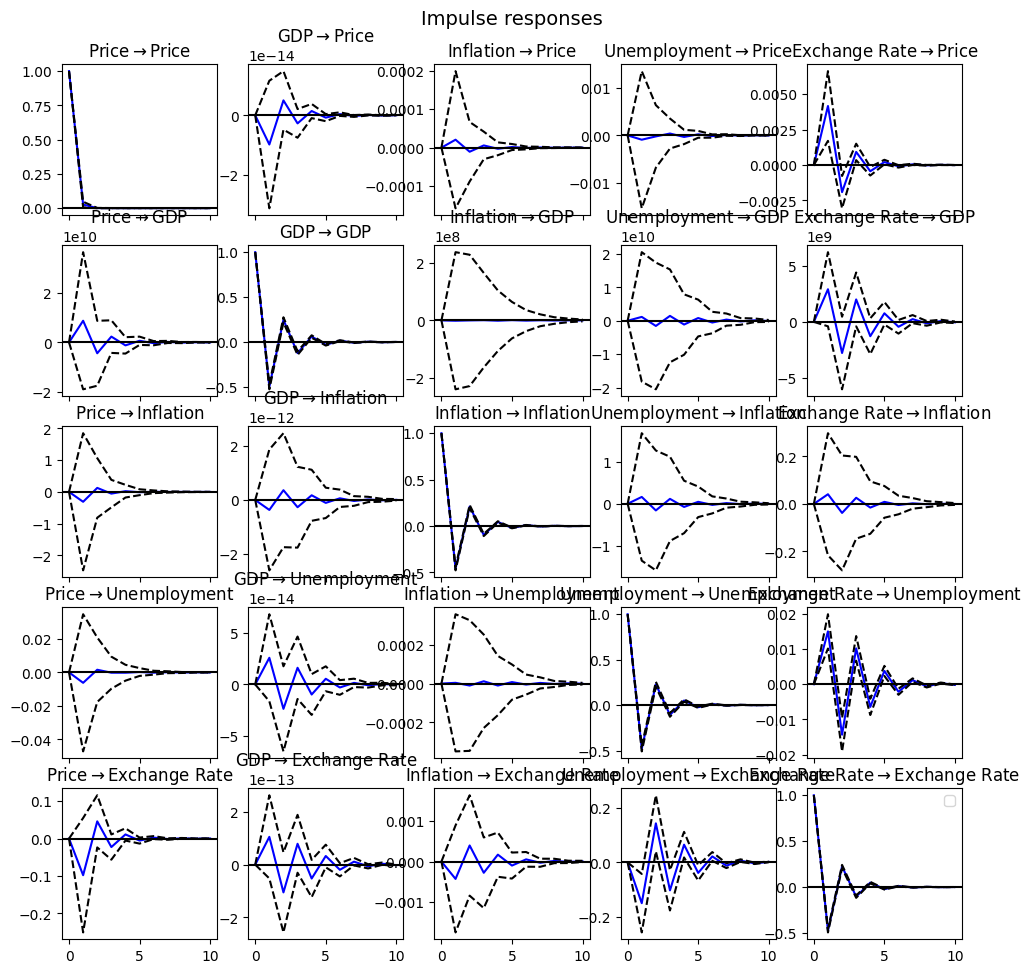

In [94]:
data_multivariate = combined_data[['Price', 'GDP', 'Inflation','Unemployment','Exchange Rate']]

data_diff = data_multivariate.diff().dropna()

from statsmodels.tsa.api import VAR
model = VAR(data_diff)
var_model = model.fit()
print(var_model.summary())

forecast = var_model.forecast(data_diff.values[-var_model.k_ar:], steps=10)
to_be_plotted = var_model.irf(10)
to_be_plotted.plot(orth=False)
# plt.plot(to_be_plotted, label='VAR Forecast')
plt.legend()
plt.show()

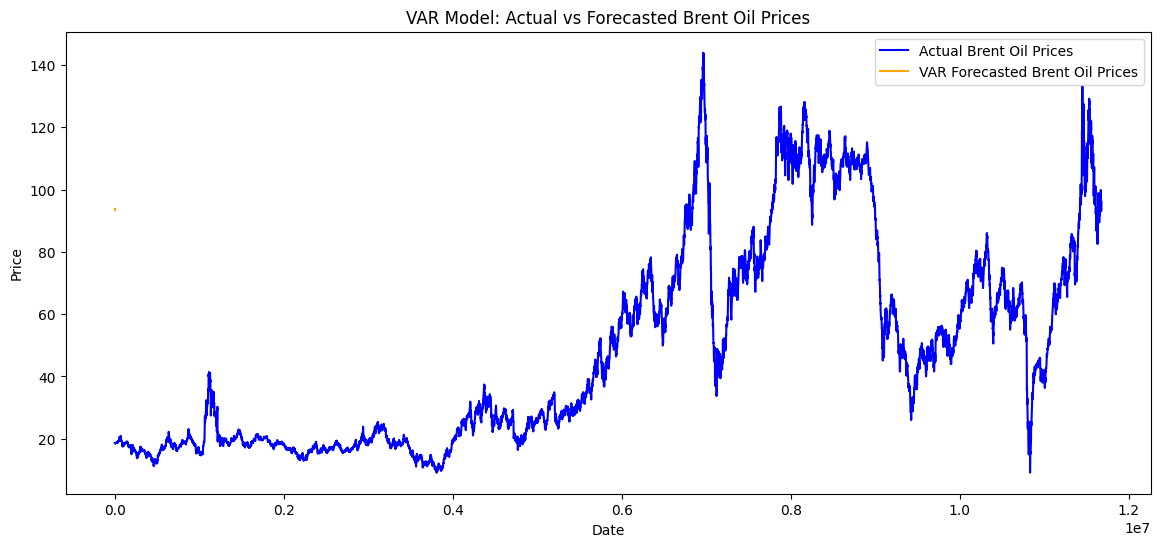

In [95]:
from statsmodels.tsa.api import VAR

# Prepare data for VAR model
model_data = combined_data[['Price', 'GDP', 'Inflation', 'Unemployment']].dropna()
model = VAR(model_data)
model_fitted = model.fit(4)

# Forecasting
forecast = model_fitted.forecast(model_data.values[-4:], steps=10)  # Forecast next 10 steps
forecast_df = pd.DataFrame(forecast, columns=model_data.columns)

# Plot actual vs forecasted values for Brent oil price
plt.figure(figsize=(14, 6))
plt.plot(model_data.index, model_data['Price'], label='Actual Brent Oil Prices', color="blue")
plt.plot(forecast_df.index, forecast_df['Price'], label='VAR Forecasted Brent Oil Prices', color="orange")
plt.title('VAR Model: Actual vs Forecasted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

>> ## Markov-Switching model

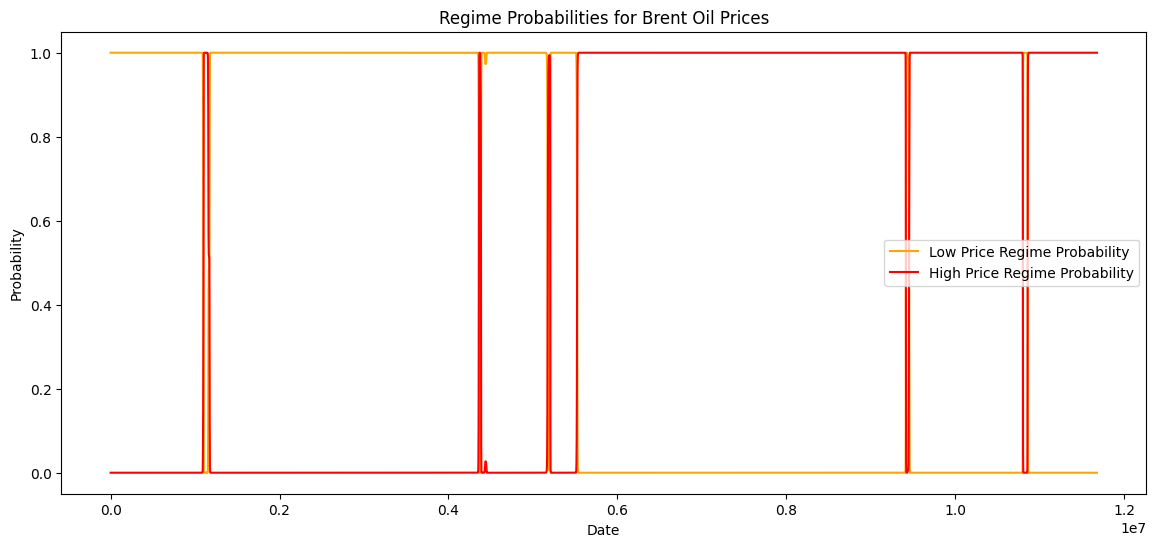

In [98]:
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Fit Markov Switching Model
markov_model = MarkovRegression(combined_data['Price'].dropna(), k_regimes=2, trend='c', switching_variance=True)
markov_fitted = markov_model.fit()

# Plot smoothed probabilities of regimes
plt.figure(figsize=(14, 6))
plt.plot(markov_fitted.smoothed_marginal_probabilities[0], label='Low Price Regime Probability', color='orange')
plt.plot(markov_fitted.smoothed_marginal_probabilities[1], label='High Price Regime Probability', color='red')
plt.title('Regime Probabilities for Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Probability')
plt.legend()
plt.show()

>> ## LSTM

Incorporating Machine Learning Models for Deeper Analysis
Objective: Use machine learning models to capture non-linear patterns and dependencies in Brent oil prices.

Methods:

Long Short-Term Memory (LSTM) Networks: Leverage LSTM for time-series forecasting.
Steps:
Data Preparation: Scale the data and structure it for LSTM input.
Model Training: Use a sequential model with LSTM layers.
Evaluation: Use out-of-sample testing and metrics like RMSE

Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - loss: 0.0130
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 4.7008e-04
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 3.7888e-04
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 2.9594e-04
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 2.7444e-04
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 2.6725e-04
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 2.2649e-04
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 1.8351e-04
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - loss: 1.8697e-04
Epoch 10/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 24s 86ms/step - loss: 1.7221e-04
280/280 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step


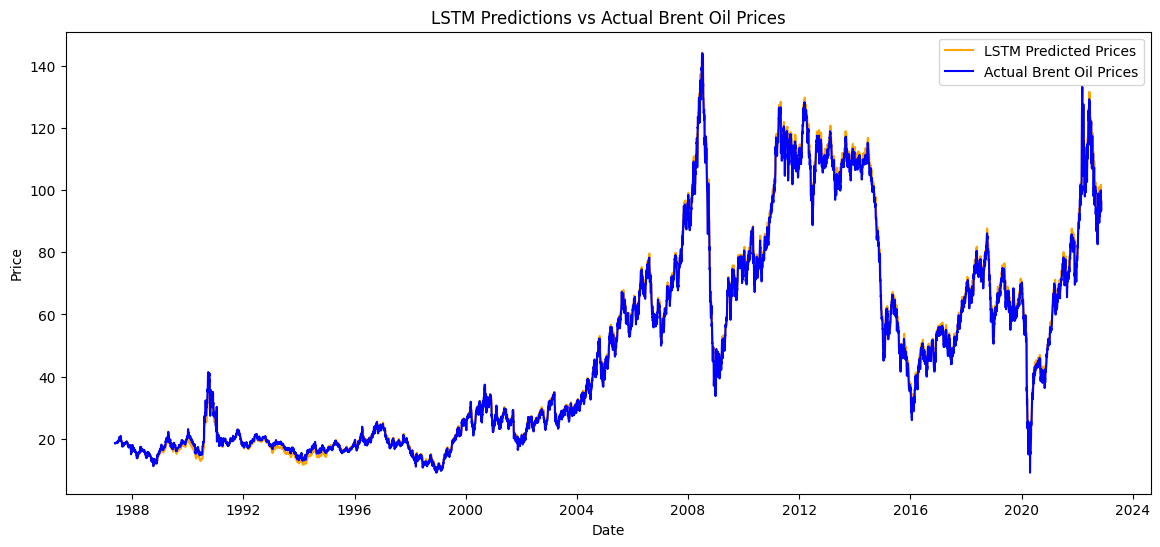

In [99]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data[['Price', 'GDP', 'Inflation', 'Unemployment','Exchange Rate']].dropna())

# Prepare data for LSTM
X, y = [], []
time_steps = 60  # Sequence length

for i in range(time_steps, len(scaled_data)):
    X.append(scaled_data[i-time_steps:i])
    y.append(scaled_data[i, 0])  

X, y = np.array(X), np.array(y)

# Define and train LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

# Make predictions
# Make predictions
predicted_prices = model.predict(X)

# Create an array with the correct shape for inverse transformation
predicted_prices_full = np.zeros((predicted_prices.shape[0], 5))  # 5 features
predicted_prices_full[:, 0] = predicted_prices.flatten()  # Fill the first column with predicted prices

# Inverse transform
predicted_prices_full = scaler.inverse_transform(predicted_prices_full)[:, 0]  # Get only the first column

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(combined_data['Date'][-len(predicted_prices):], predicted_prices_full, label='LSTM Predicted Prices', color="orange")
plt.plot(combined_data['Date'], combined_data['Price'], label='Actual Brent Oil Prices', color="blue")
plt.title('LSTM Predictions vs Actual Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


>> ## Model Evaluation and Performance Metrics

Comparative Model Evaluation
Insight: By evaluating model performance metrics (RMSE, MAE, and R-squared), you can see which model performs best for specific scenarios:
Low RMSE and MAE: Suggest the model is accurately predicting values close to the actual prices.
High R-squared: Implies the model can explain a significant portion of the variance in the data.

LSTM Model RMSE: 58.30473805010458
LSTM Model MAE: 48.31750303714882


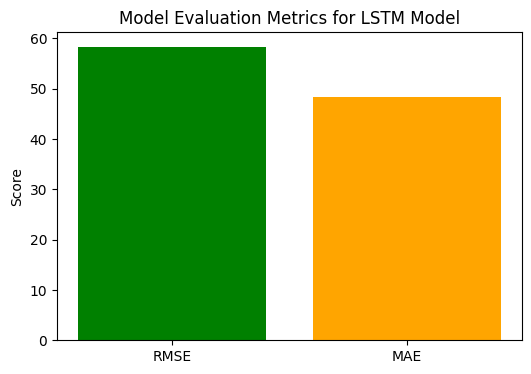

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE and MAE for LSTM model
rmse = np.sqrt(mean_squared_error(combined_data['Price'][-len(predicted_prices):], predicted_prices))
mae = mean_absolute_error(combined_data['Price'][-len(predicted_prices):], predicted_prices)

print(f"LSTM Model RMSE: {rmse}")
print(f"LSTM Model MAE: {mae}")

# Bar plot for evaluation metrics
metrics = {'RMSE': rmse, 'MAE': mae}
plt.figure(figsize=(6, 4))
plt.bar(metrics.keys(), metrics.values(), color=['green', 'orange'])
plt.title('Model Evaluation Metrics for LSTM Model')
plt.ylabel('Score')
plt.show()



>> ## Insight Generation and Analysis

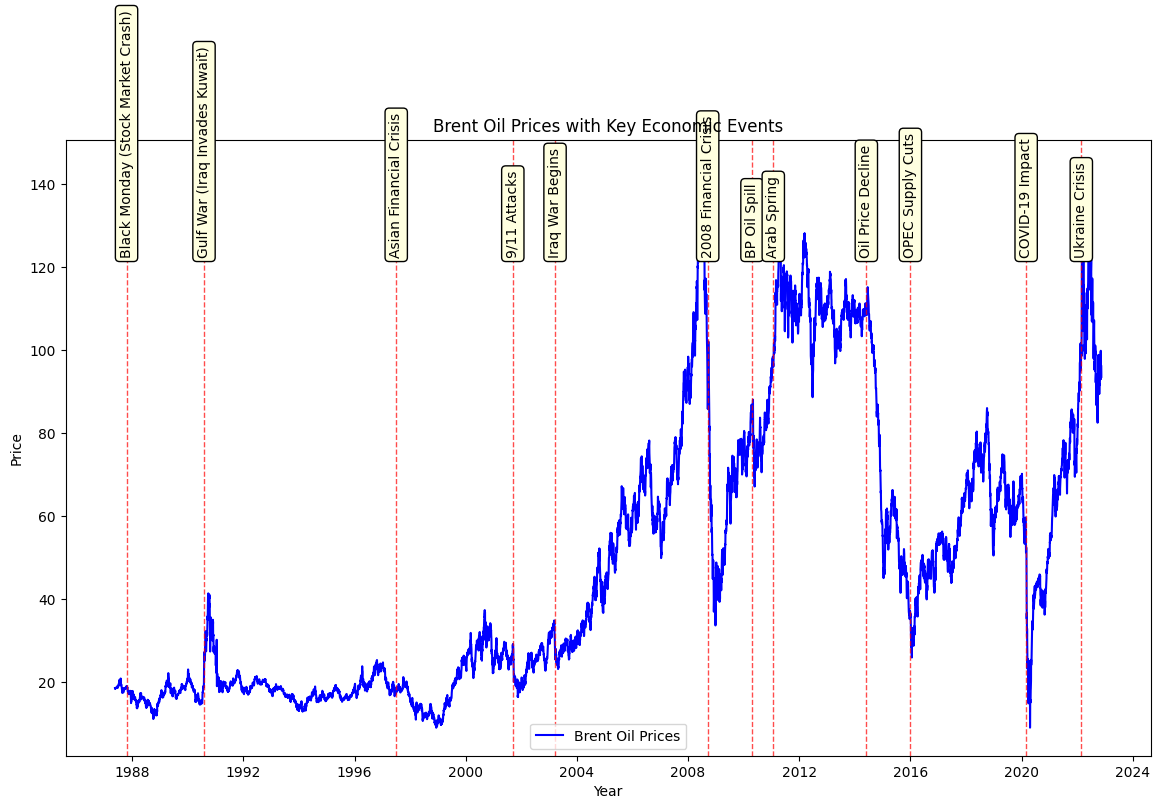

In [102]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data for the events we want to annotate
events = {
    '1987-10-19': 'Black Monday (Stock Market Crash)',
    '1990-08-02': 'Gulf War (Iraq Invades Kuwait)',
    '1997-07-02': 'Asian Financial Crisis',
    '2001-09-11': '9/11 Attacks',
    '2003-03-20': 'Iraq War Begins',
    '2008-09-15': '2008 Financial Crisis',
    '2010-04-20': 'BP Oil Spill',
    '2011-01-25': 'Arab Spring',
    '2014-06-01': 'Oil Price Decline',
    '2016-01-01': 'OPEC Supply Cuts',
    '2020-03-01': 'COVID-19 Impact',
    '2022-02-24': 'Ukraine Crisis'
}

# Plotting the Brent oil prices with annotated events
plt.figure(figsize=(14, 8))
plt.plot(combined_data['Date'], combined_data['Price'], label='Brent Oil Prices', color='blue')

# Loop over each event in the dictionary and plot it with a vertical line and annotation
for date, label in events.items():
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--', linewidth=1, alpha=0.7)
    plt.annotate(label, 
                 xy=(pd.to_datetime(date), combined_data['Price'].max() * 0.8), 
                 xytext=(pd.to_datetime(date), combined_data['Price'].max() * 0.85),
                 rotation=90, color='black', 
                 ha='center', va='bottom', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"))

# Adding labels and title
plt.title('Brent Oil Prices with Key Economic Events')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()


>> ## Back Testing and Validation

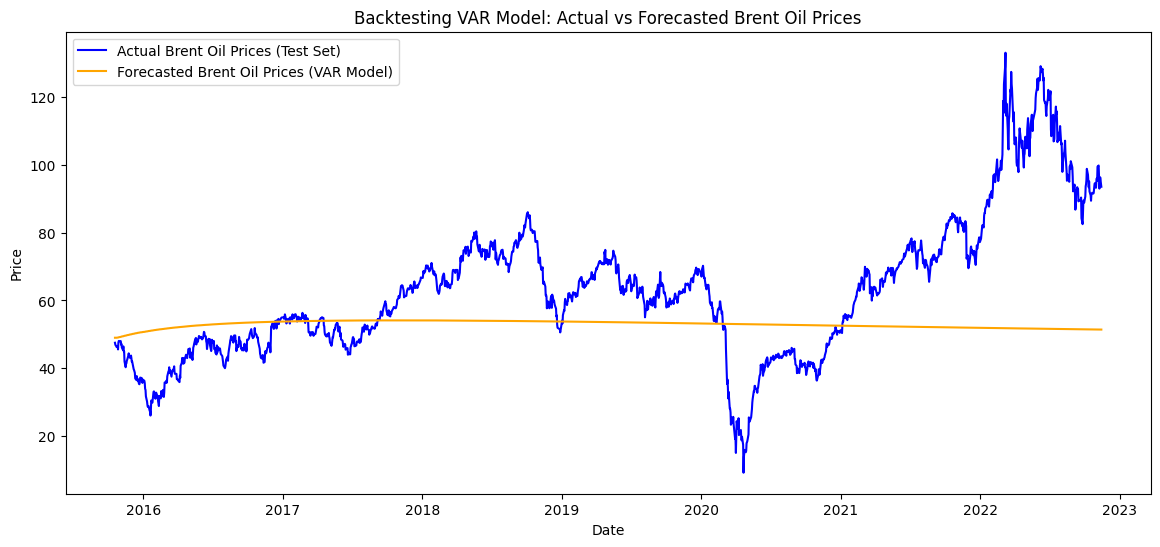

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Check and align date indexing for model_data and combined_data
model_data.index = pd.to_datetime(combined_data['Date'])
train_size = int(len(model_data) * 0.8)
train, test = model_data.iloc[:train_size], model_data.iloc[train_size:]

# Fit VAR model on training data
var_model = VAR(train)
var_model_fitted = var_model.fit(4)

# Forecast on the test set
forecasted_values = var_model_fitted.forecast(train.values[-4:], steps=len(test))

# Use the dates from the test set in combined_data to set the forecasted_df index
forecasted_df = pd.DataFrame(forecasted_values, columns=test.columns)
forecasted_df.index = test.index  # Ensure forecast aligns with test dates

# Plotting test set vs forecasted values
plt.figure(figsize=(14, 6))
plt.plot(test.index, test['Price'], label='Actual Brent Oil Prices (Test Set)', color="blue")
plt.plot(forecasted_df.index, forecasted_df['Price'], label='Forecasted Brent Oil Prices (VAR Model)', color="orange")
plt.title('Backtesting VAR Model: Actual vs Forecasted Brent Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [104]:
import pandas as pd
tech_data = pd.read_csv('./docs/technological_data.csv')

In [105]:
tech_data[tech_data['Oil_Imports_Quantity'].notna()].head(4)

Unnamed: 0   index  Oil_Price    year  price_diff  index.1    value  \
161  2022-06-30  8915.0     119.78  2022.0       -1.02     29.5  19.6305   
162  2022-07-31     NaN        NaN     NaN         NaN      9.5  21.0090   

     Natural_Gas_Value  index.2  Coal_Consumption  index.3  value.1  \
161            19.6305      0.0               0.0      NaN      NaN   
162            21.0090  42778.0       947715042.9      NaN      NaN   

     Renewable_Energy_Value    index.4  Oil_Imports_Quantity  Oil_Price_Diff  \
161                     NaN  3224529.0             1478327.0       -4.580578   
162                     NaN  7199305.0             5726308.0        0.000000   

     Natural_Gas_Rolling  
161            16.425500  
162            18.852667

In [106]:
print(len(tech_data))
tech_data.isna().sum()

163


Unnamed: 0                  0
index                      53
Oil_Price                  53
year                       53
price_diff                 53
index.1                     0
value                       0
Natural_Gas_Value           0
index.2                   114
Coal_Consumption          114
index.3                   163
value.1                   163
Renewable_Energy_Value    163
index.4                   161
Oil_Imports_Quantity      161
Oil_Price_Diff              3
Natural_Gas_Rolling         2
dtype: int64

In [107]:
tech_data_real = tech_data[['Oil_Price','year','price_diff','value','Natural_Gas_Value','Oil_Price_Diff','Natural_Gas_Rolling']]


In [108]:
tech_data_cleaned = tech_data_real.dropna(axis=0)

tech_data_cleaned.isna().sum()

Oil_Price              0
year                   0
price_diff             0
value                  0
Natural_Gas_Value      0
Oil_Price_Diff         0
Natural_Gas_Rolling    0
dtype: int64

In [109]:
tech_data_cleaned.to_csv('./docs/technological_data.csv')